In [2]:
import tarfile
import netCDF4 as nc
from netCDF4 import Dataset
import os
import xarray as xr


# Define the path to the tar.gz file and the extraction directory
tar_gz_path = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\example_output.tar.gz"
extraction_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)"

In [4]:
# Directory containing the NetCDF files
data_surface_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL"
data_routing_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\ROUTING"

In [6]:
# Function to recursively find all .nc files in a directory
def find_nc_files(directory):
    nc_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nc'):
                nc_files.append(os.path.join(root, file))
    return nc_files

In [8]:
# Find all .nc files in each directory
surface_files = find_nc_files(data_surface_dir)
routing_files = find_nc_files(data_routing_dir)

# Check if files were found
print(f'Found {len(surface_files)} files in surfacemodel')
print(f'Found {len(routing_files)} files in routing')

# Load datasets
ds_surface = xr.open_mfdataset(surface_files, combine='by_coords')
ds_routing = xr.open_mfdataset(routing_files, combine='by_coords')

Found 15339 files in surfacemodel
Found 5113 files in routing


In [10]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [12]:
# Extract latitude, longitude, and soil moisture values from ds_surface
latitude = ds_surface['lat'].values
longitude = ds_surface['lon'].values
longitude.shape

(5113, 36, 34)

In [14]:
# Extract the soil moisture data
soil_moisture = ds_surface['SoilMoist_tavg']
soil_moisture_avg = ds_surface['SoilMoist_tavg'].mean(axis=0).values  # Average over all layers
print(soil_moisture.shape)
print(soil_moisture_avg.shape)

(5113, 4, 36, 34)
(4, 36, 34)


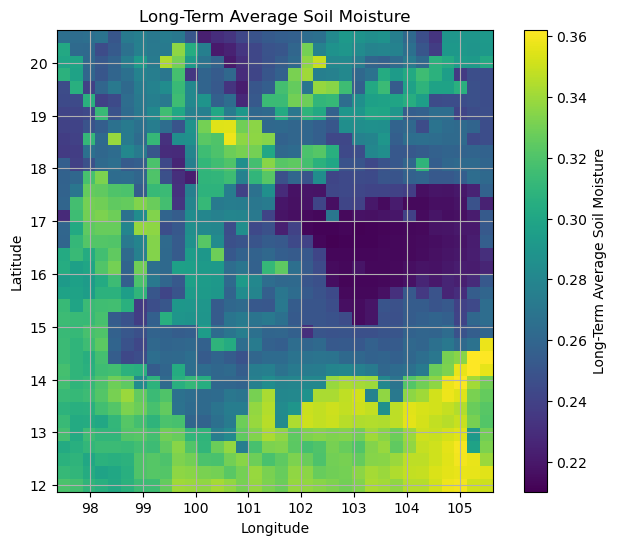

In [26]:
# Plotting
plt.figure(figsize=(8, 6))

plt.imshow(soil_moisture_avg[0,:,:], extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), cmap='viridis')
plt.colorbar(label='Long-Term Average Soil Moisture')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Long-Term Average Soil Moisture')
plt.grid(True)
plt.show()

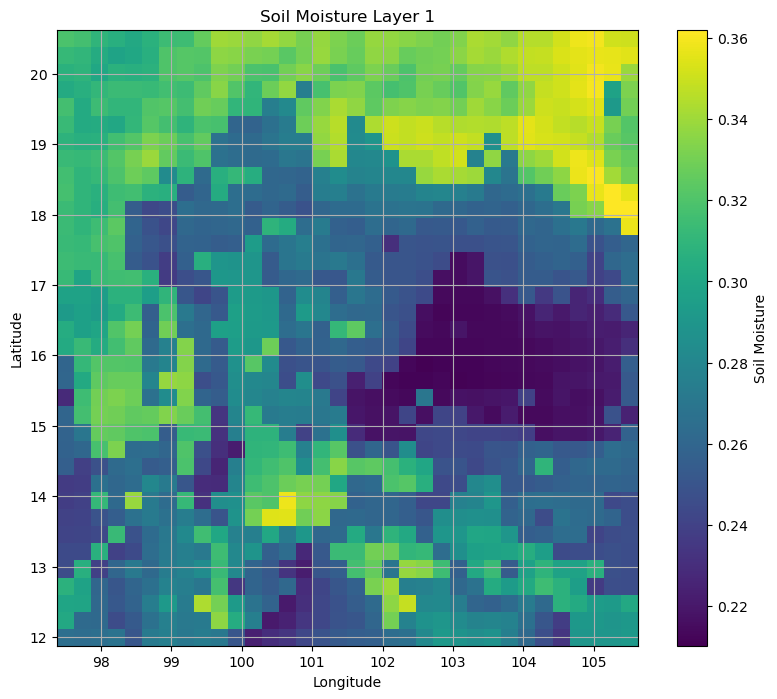

<Figure size 640x480 with 0 Axes>

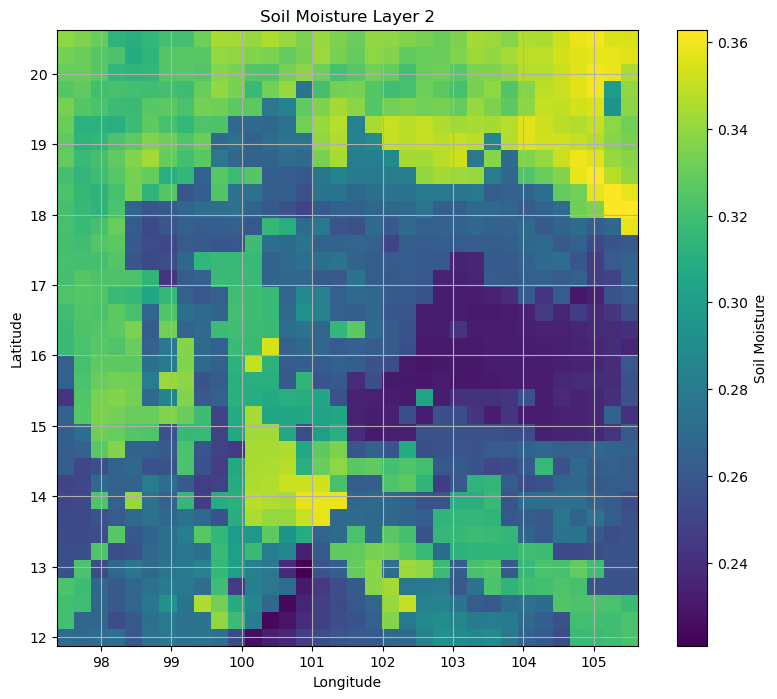

<Figure size 640x480 with 0 Axes>

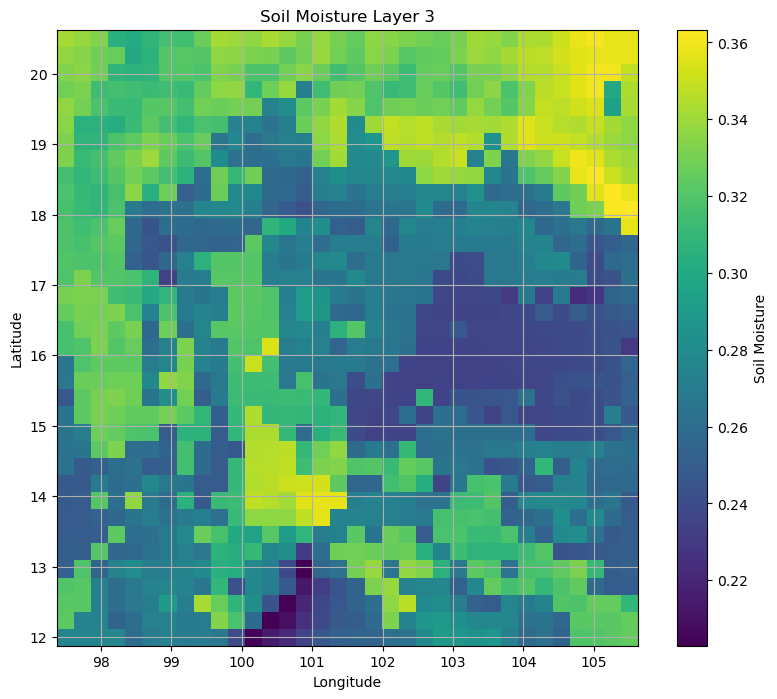

<Figure size 640x480 with 0 Axes>

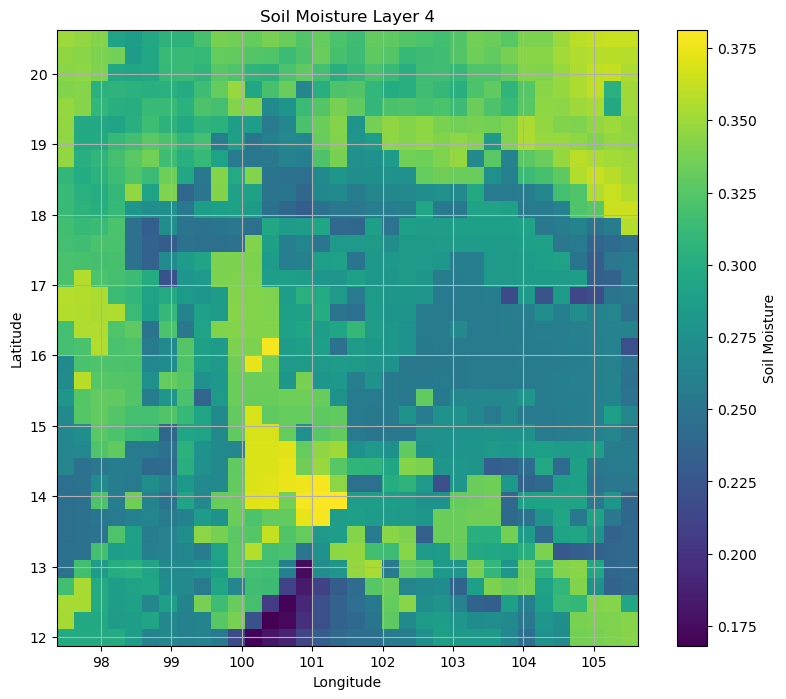

<Figure size 640x480 with 0 Axes>

In [34]:
# Plotting each layer
for layer_idx in range(soil_moisture_avg.shape[0]):
    # Select data for the current layer
    layer_soil_moisture = soil_moisture_avg[layer_idx, :, :]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(layer_soil_moisture, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), cmap='viridis', origin='lower')
    plt.colorbar(label='Soil Moisture')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Soil Moisture Layer {layer_idx + 1}')
    plt.grid(True)
    plt.show()

    # Optionally, save the plot
    plt.savefig(f'soil_moisture_layer_{layer_idx + 1}.png')

In [16]:
# Number of layers
num_layers = soil_moisture.shape[1]
print(num_layers)

4


In [18]:
soil_moisture.units

'm^3 m-3'

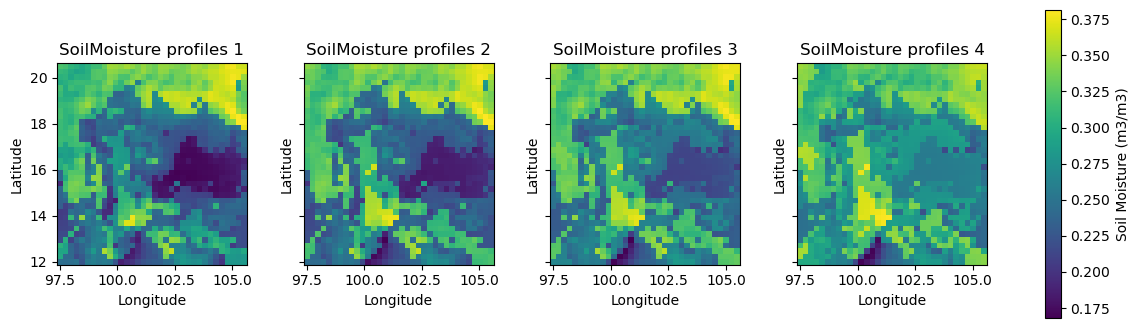

In [42]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_layers, figsize=(15, 4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot each layer
for layer_idx in range(num_layers):
    ax = axes[layer_idx]
    layer_soil_moisture = soil_moisture_avg[layer_idx, :, :]
    
    cax = ax.imshow(layer_soil_moisture, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), cmap='viridis', origin='lower')
    ax.set_title(f'SoilMoisture profiles {layer_idx + 1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
# Add a colorbar
fig.colorbar(cax, ax=axes, label='Soil Moisture (m3/m3)') #orientation='horizontal', 

plt.show()

In [20]:
# Convert time dimension to a pandas DatetimeIndex
time_index = pd.to_datetime(ds_surface['time'].values)
print(time_index.shape)

(5113,)


In [22]:
# Loop through each year and plot
years = np.unique(time_index.year)
print(years.shape)

(15,)


In [24]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [26]:
# Select a specific layer to plot (e.g., the first layer)
selected_layer_idx = 0  # Change to select different layers

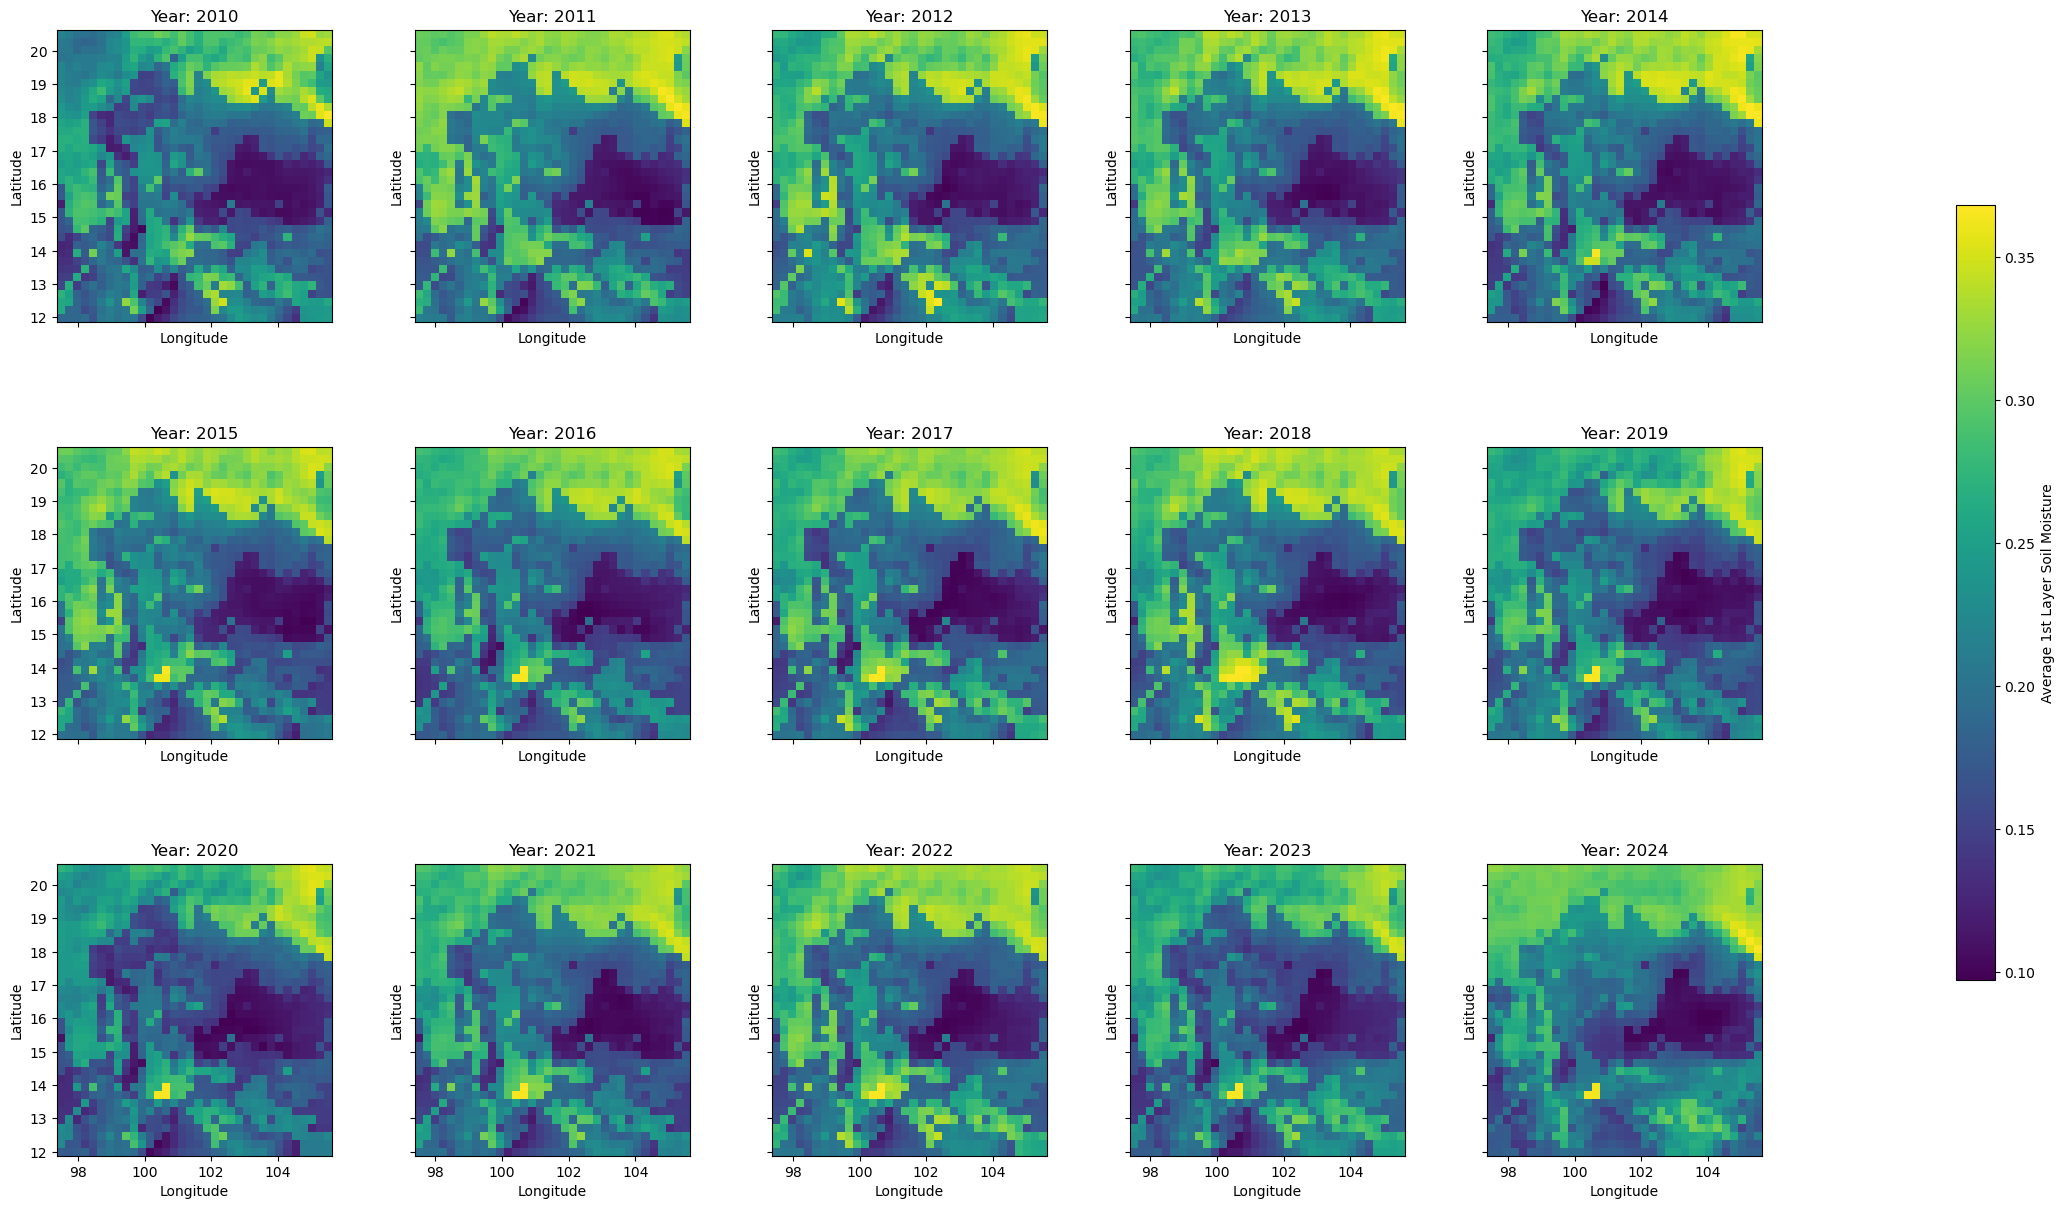

In [54]:
# Create subplots for each year with 5 columns and 3 rows
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the selected layer for each year
for year_idx, year in enumerate(years):
    # Select data for the current year
    year_mask = (time_index.year == year)
    
    # Compute average soil moisture for the current year and selected layer
    yearly_soil_moisture = soil_moisture[year_mask, selected_layer_idx, :, :].mean(axis=0)  # Average over time points in the year

    ax = axes[year_idx]
    cax = ax.imshow(yearly_soil_moisture, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), cmap='viridis', origin='lower')
    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Add a single colorbar for the entire plot
fig.colorbar(cax, ax=axes.ravel().tolist(), label='Average 1st Layer Soil Moisture', fraction=0.02, pad=0.1) #orientation='horizontal', 

plt.show()

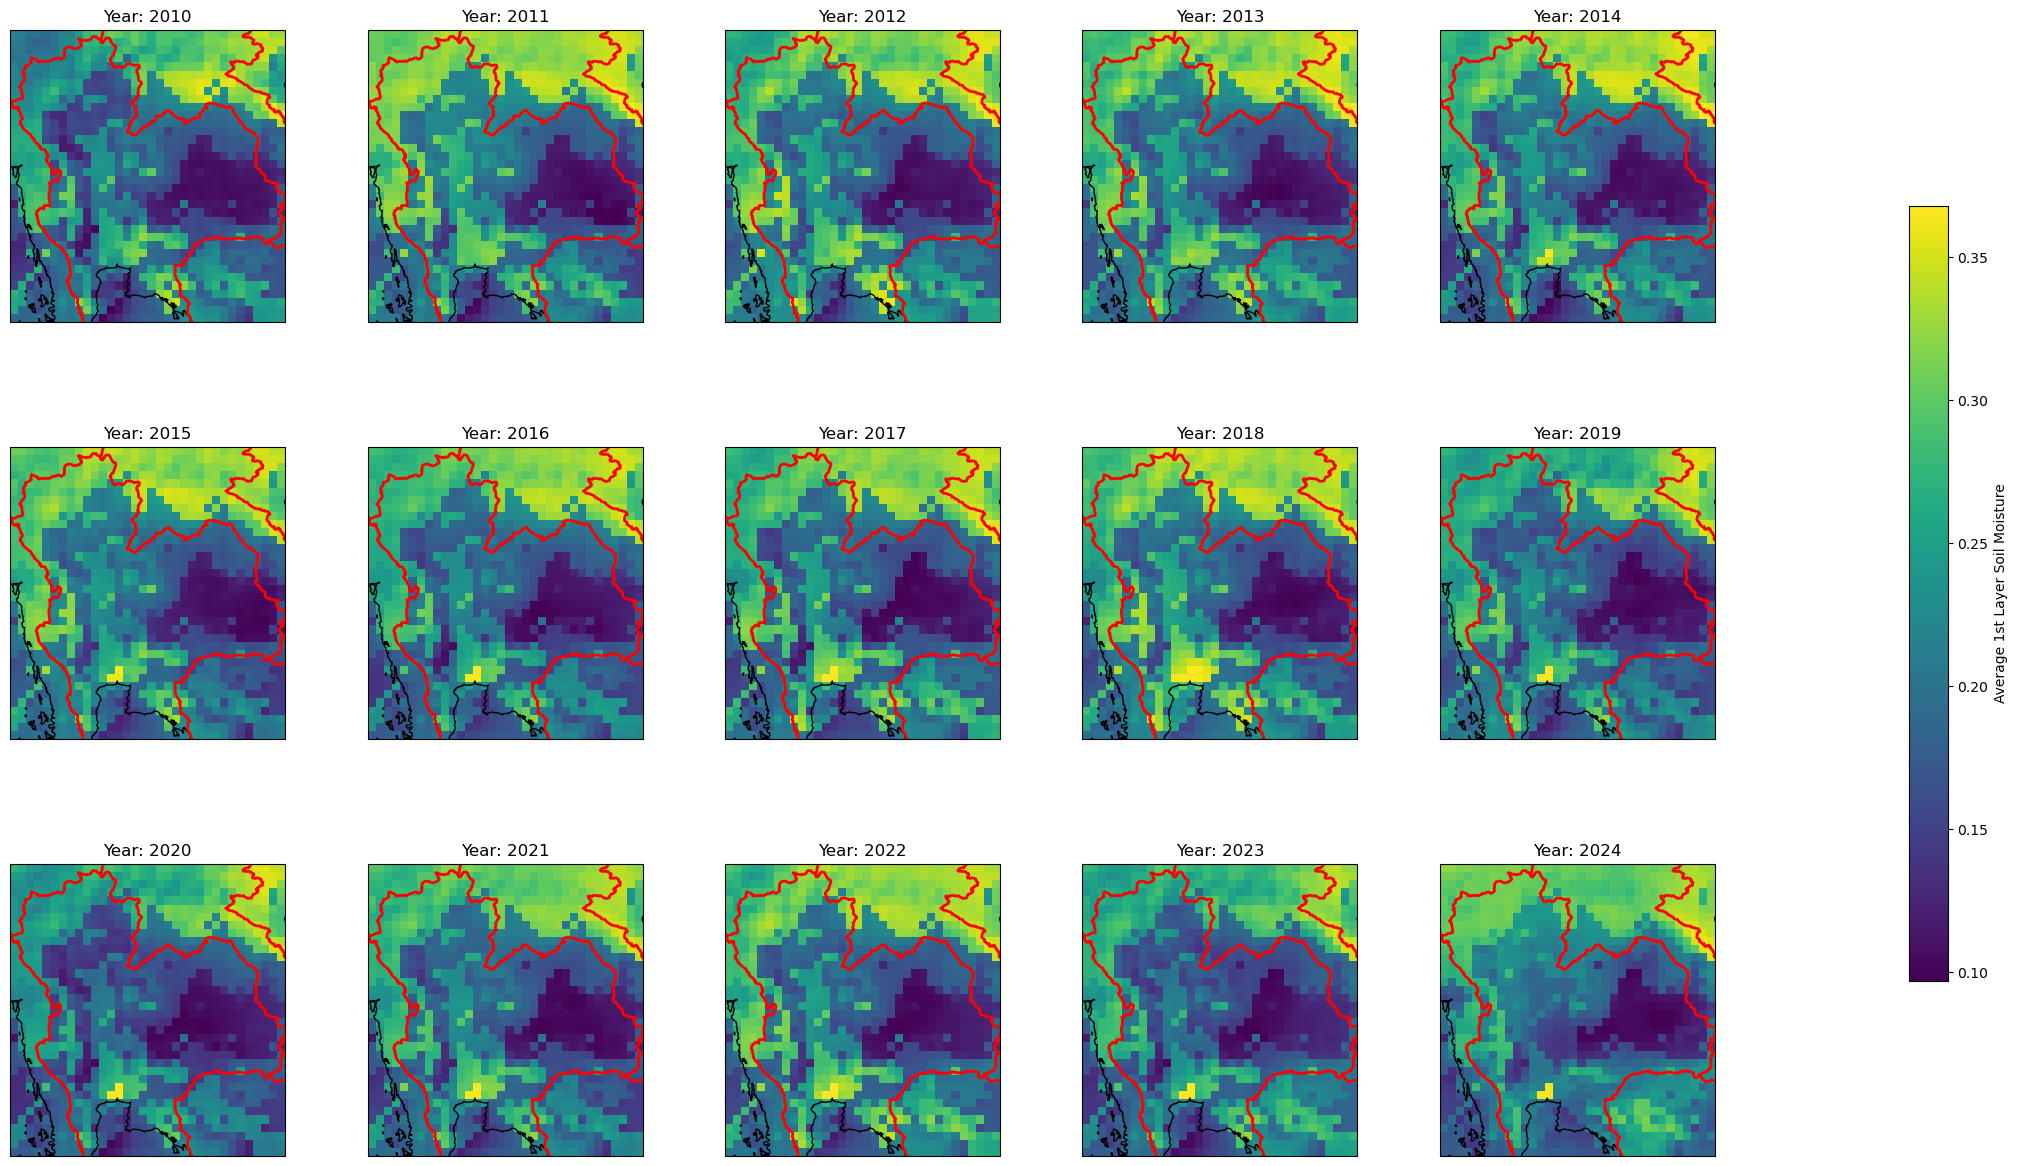

In [56]:
# Create subplots for each year with 5 columns and 3 rows, using Cartopy's PlateCarree projection
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the selected layer for each year
for year_idx, year in enumerate(years):
    if year_idx >= len(axes):  # Avoid index error if there are more years than subplots
        break
        
    # Select data for the current year
    year_mask = (time_index.year == year)
    
    # Compute average soil moisture for the current year and selected layer
    yearly_soil_moisture = soil_moisture[year_mask, selected_layer_idx, :, :].mean(axis=0)  # Average over time points in the year

    ax = axes[year_idx]
    # Plot data with geographic projection
    cax = ax.imshow(yearly_soil_moisture, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), 
                    cmap='viridis', origin='lower', transform=ccrs.PlateCarree())
    ax.set_title(f'Year: {year}')
    
    # Set extent for each subplot
    ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()], crs=ccrs.PlateCarree())
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')

# Add a single colorbar for the entire plot
fig.colorbar(cax, ax=axes, label='Average 1st Layer Soil Moisture', fraction=0.02, pad=0.1) #orientation='horizontal', 

plt.show()

In [28]:
# **Combine layers** by averaging across the second dimension (layers)
combined_soil_moisture = soil_moisture.mean(axis=1)  # Shape: (time, north_south, east_west)

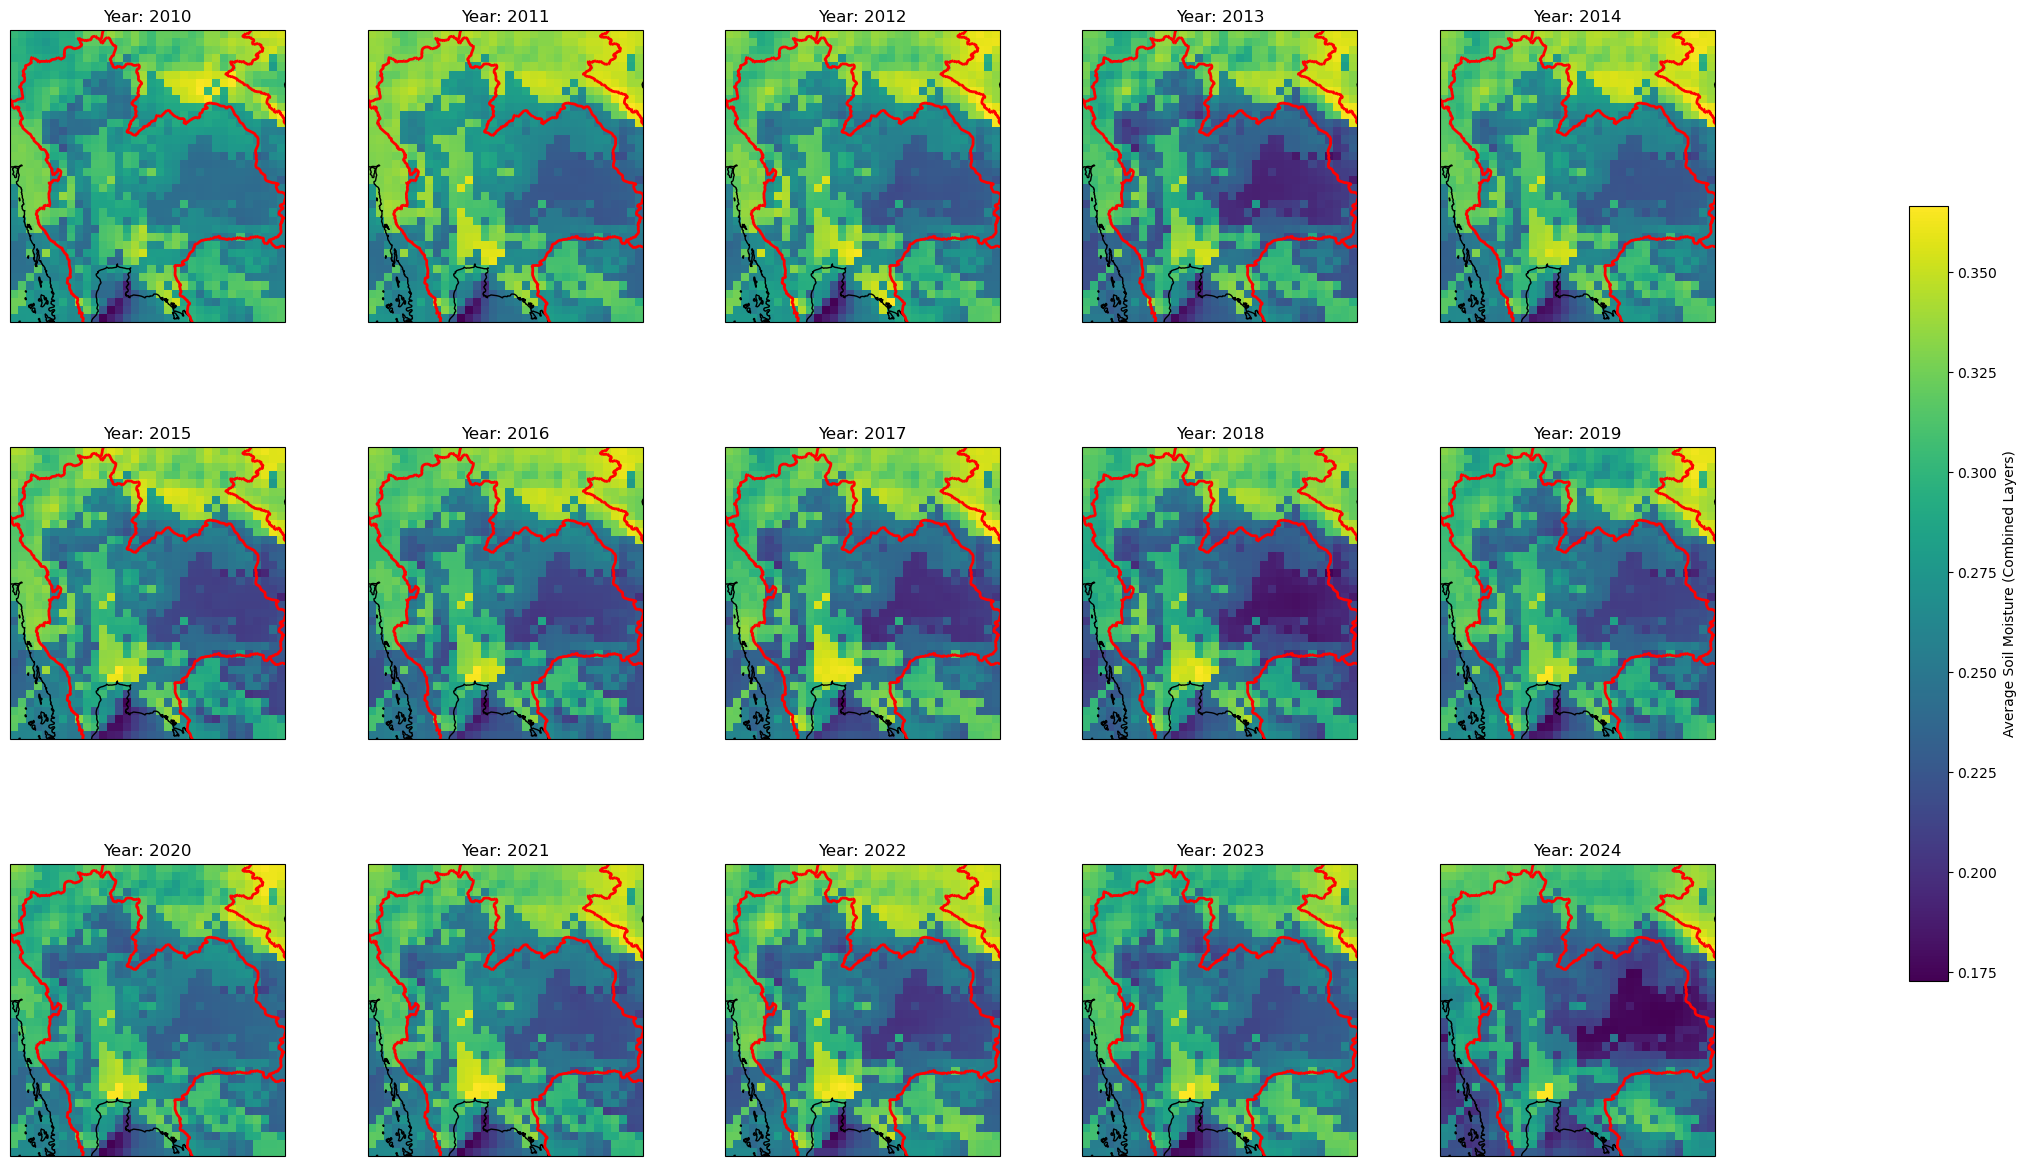

In [60]:
# Create subplots for each year with 5 columns and 3 rows, using Cartopy's PlateCarree projection
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the combined soil moisture for each year
for year_idx, year in enumerate(years):
    if year_idx >= len(axes):  # Avoid index error if there are more years than subplots
        break
        
    # Select data for the current year
    year_mask = (time_index.year == year)
    
    # Compute average combined soil moisture for the current year
    yearly_soil_moisture = combined_soil_moisture[year_mask, :, :].mean(axis=0)  # Average over time points in the year

    ax = axes[year_idx]
    # Plot data with geographic projection
    cax = ax.imshow(yearly_soil_moisture, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), 
                    cmap='viridis', origin='lower', transform=ccrs.PlateCarree())
    ax.set_title(f'Year: {year}')
    
    # Set extent for each subplot
    ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()], crs=ccrs.PlateCarree())
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')

# Add a single colorbar for the entire plot
fig.colorbar(cax, ax=axes, label='Average Soil Moisture (Combined Layers)', fraction=0.02, pad=0.1) #orientation='horizontal', 

plt.show()

In [30]:
# Ensure latitude and longitude are 2D arrays
latitude_2D = ds_surface['lat'].values[0, :, :]  # Shape: (north_south, east_west)
longitude_2D = ds_surface['lon'].values[0, :, :]  # Shape: (north_south, east_west)

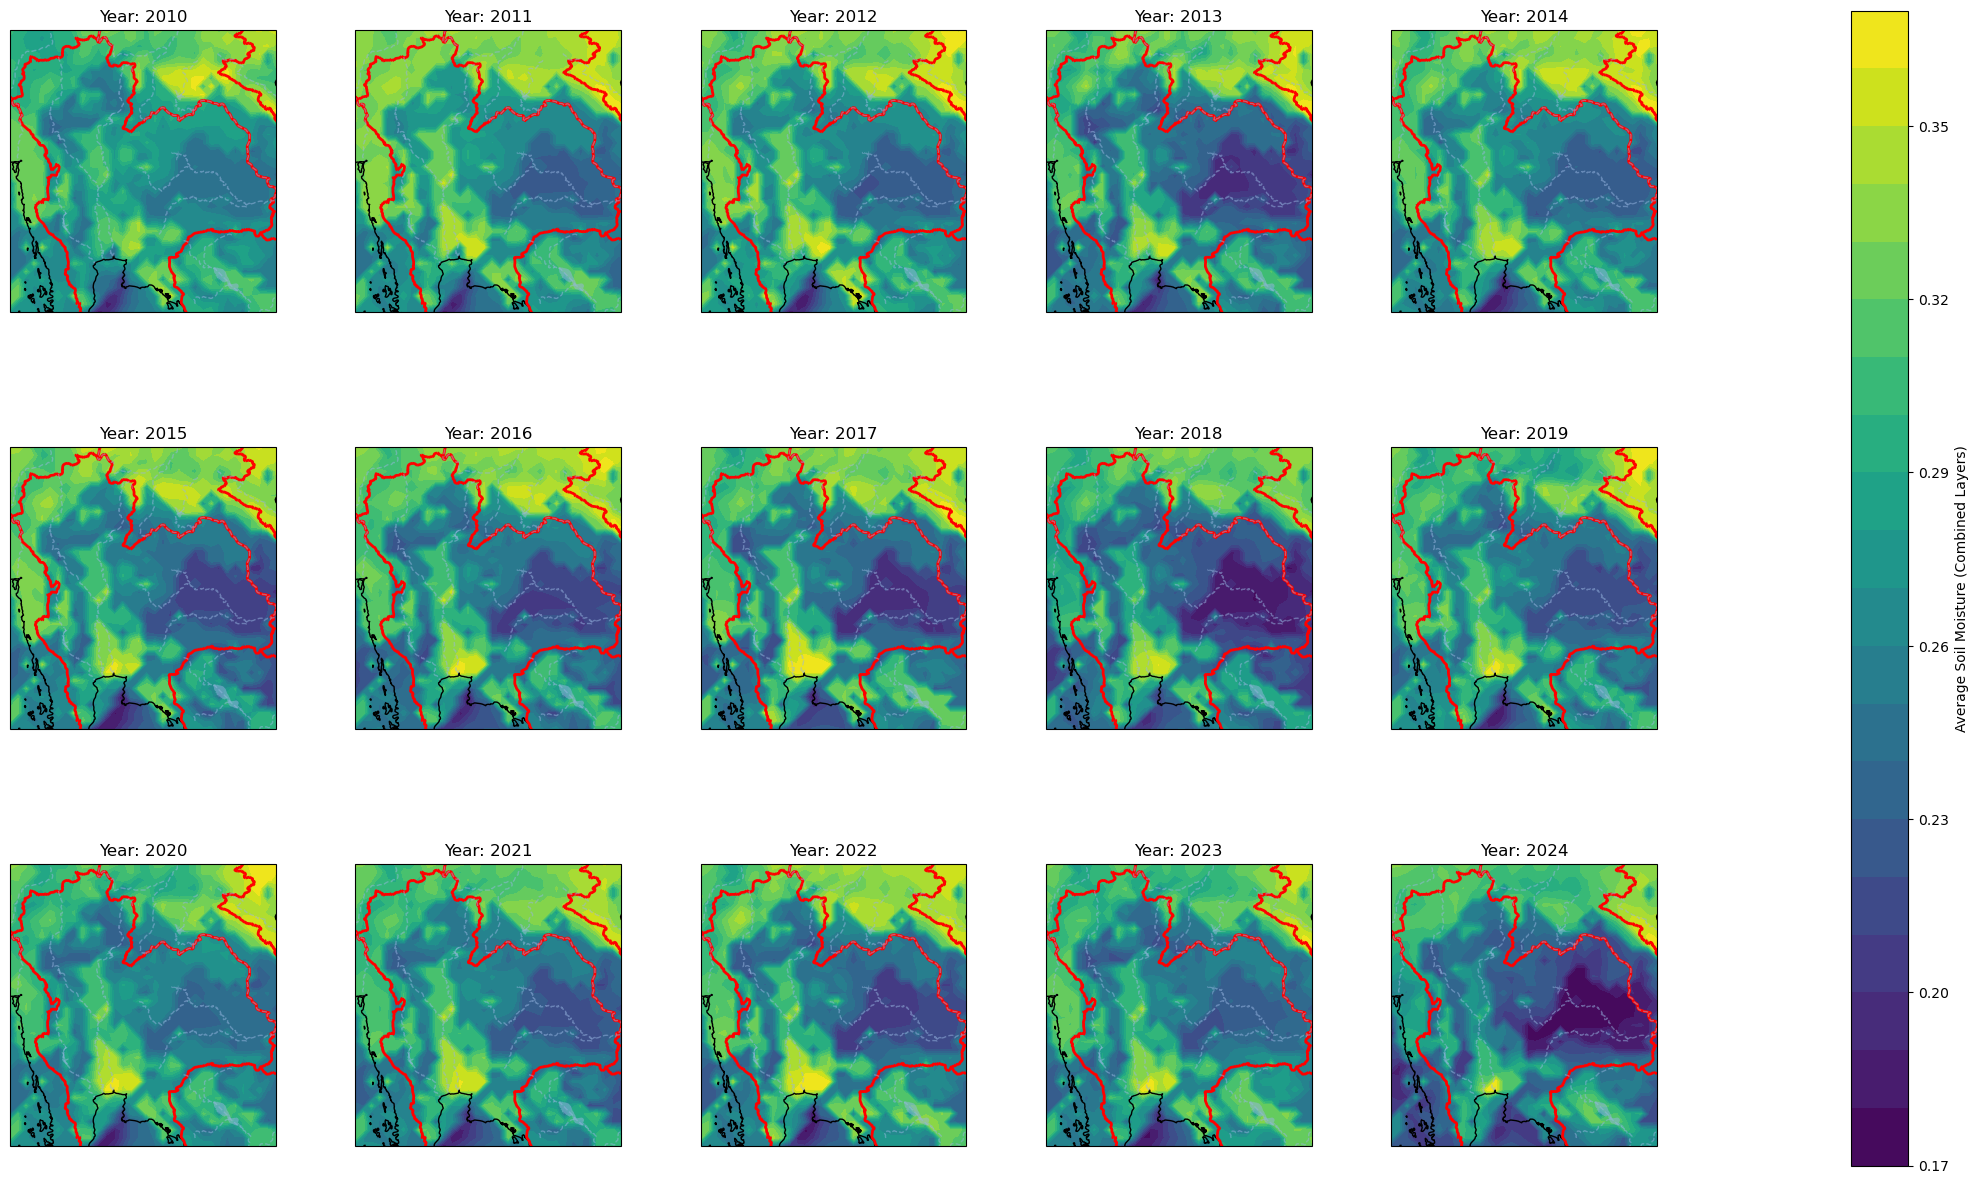

In [70]:
# Create subplots for each year with 5 columns and 3 rows, using Cartopy's PlateCarree projection
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the combined soil moisture for each year
for year_idx, year in enumerate(years):
    if year_idx >= len(axes):  # Avoid index error if there are more years than subplots
        break
        
    # Select data for the current year
    year_mask = (time_index.year == year)
    
    # Compute average combined soil moisture for the current year
    yearly_soil_moisture = combined_soil_moisture[year_mask, :, :].mean(axis=0)  # Average over time points in the year

    ax = axes[year_idx]
    
    # Plot data with contourf and geographic projection
    contour = ax.contourf(longitude_2D, latitude_2D, yearly_soil_moisture, 
                          levels=20, cmap='viridis', transform=ccrs.PlateCarree())
    
    ax.set_title(f'Year: {year}')
    
    # Set extent for each subplot
    ax.set_extent([longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()], crs=ccrs.PlateCarree())
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linestyle='--', alpha=0.5)

# Add a single colorbar for the entire plot
cbar = fig.colorbar(contour, ax=axes, label='Average Soil Moisture (Combined Layers)', fraction=0.05, pad=0.1) #orientation='horizontal', 

plt.show()

In [32]:
# Calculate the long-term average and standard deviation across all time points
long_term_average = combined_soil_moisture.mean(axis=0)  # Shape: (north_south, east_west)
long_term_std = combined_soil_moisture.std(axis=0)  # Shape: (north_south, east_west)

In [30]:
years[14]

2024

In [34]:
# Compute average combined soil moisture for the current year 
year2024_soil_moisture = combined_soil_moisture[years[14], :, :].mean(axis=0)  # Average over time points in the year

In [36]:
print(long_term_average.shape)
print(long_term_std.shape)
print(year2024_soil_moisture.shape)

(36, 34)
(36, 34)
(34,)


In [38]:
anomaly_year2024 = (year2024_soil_moisture - long_term_average) / long_term_std

In [40]:
anomaly_year2024.shape

(34, 36)

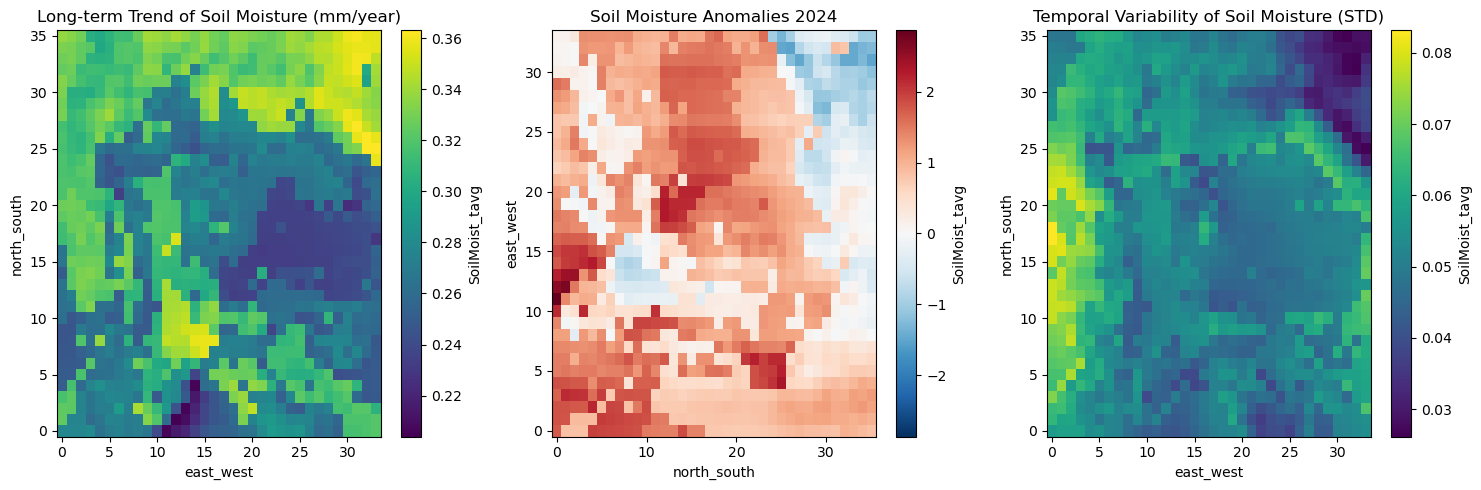

In [112]:
from scipy.stats import linregress

#Plotting the Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Ensure we create 3 subplots

# Plot the long-term trend
long_term_average.plot(ax=axes[0])
axes[0].set_title('Long-term Trend of Soil Moisture (mm/year)')

# Plot anomalies for the first time slice as an example
anomaly_year2024.plot(ax=axes[1])
axes[1].set_title('Soil Moisture Anomalies 2024')

# Plot temporal variability
long_term_std.plot(ax=axes[2])
axes[2].set_title('Temporal Variability of Soil Moisture (STD)')

plt.tight_layout()
plt.show()

In [ ]:
#Set contour levels from -3 to +3 standard deviations to visualize the range of anomalies.

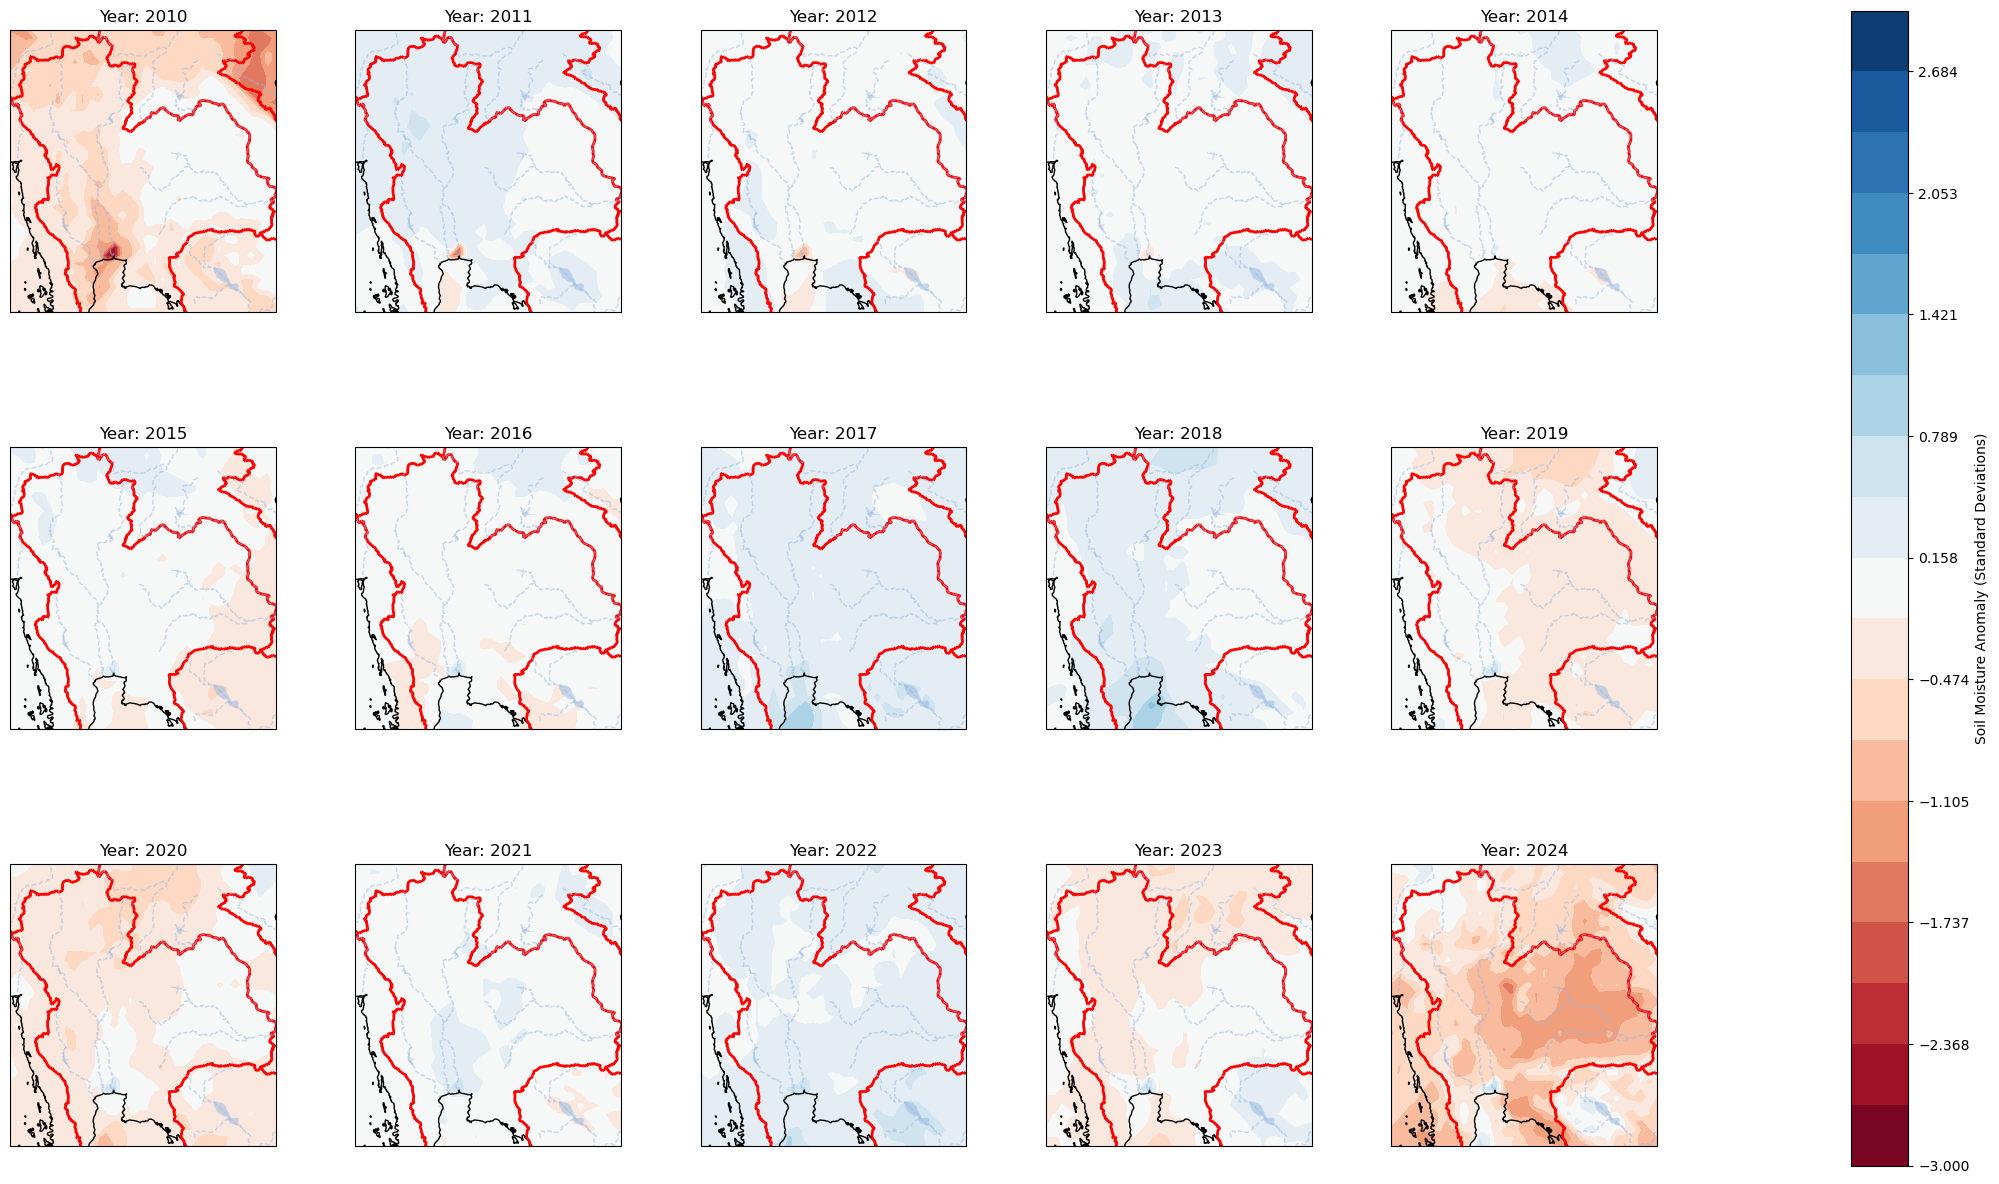

In [114]:
# Create subplots for each year with 5 columns and 3 rows, using Cartopy's PlateCarree projection
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the anomaly in standard deviations for each year
for year_idx, year in enumerate(years):
    if year_idx >= len(axes):  # Avoid index error if there are more years than subplots
        break
        
    # Select data for the current year
    year_mask = (time_index.year == year)
    
    # Compute average combined soil moisture for the current year
    yearly_soil_moisture = combined_soil_moisture[year_mask, :, :].mean(axis=0)  # Average over time points in the year
    
    # Calculate the anomaly as standard deviations from the long-term average
    anomaly_std_dev = (yearly_soil_moisture - long_term_average) / long_term_std  # Shape: (north_south, east_west)

    ax = axes[year_idx]
    
    # Plot data with contourf and geographic projection
    contour = ax.contourf(longitude_2D, latitude_2D, anomaly_std_dev, 
                          levels=np.linspace(-3, 3, 20), cmap='RdBu', transform=ccrs.PlateCarree())
    
    ax.set_title(f'Year: {year}')
    
    # Set extent for each subplot
    ax.set_extent([longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()], crs=ccrs.PlateCarree())
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linestyle='--', alpha=0.5)

# Hide any remaining empty subplots
for ax in axes[year_idx + 1:]:
    ax.axis('off')

# Add a single colorbar for the entire plot
cbar = fig.colorbar(contour, ax=axes, label='Soil Moisture Anomaly (Standard Deviations)', fraction=0.05, pad=0.1) #orientation='horizontal', 

plt.show()

In [ ]:
#Positive Anomalies: above the long-term average : excessive rainfall, reduced evaporation, cooler temperatures, or other factors.
#Negative Anomalies : below the long-term average : drought, higher temperatures leading to more evaporation, less rainfall, or other factors.

In [42]:
#Data Aggregation: Convert daily data to monthly, seasonal, and annual means.
from scipy.stats import theilslopes
import pymannkendall as mk

In [44]:
#Aggregate daily data into monthly, seasonal, and annual means
soil_moisture_monthly = soil_moisture.resample(time='1ME').mean()
soil_moisture_seasonal = soil_moisture.resample(time='QS-DEC').mean()  # Seasonal mean, starting in December
soil_moisture_annual = soil_moisture.resample(time='1YE').mean()

In [46]:
print(soil_moisture_monthly.shape)
print(soil_moisture_seasonal.shape)
print(soil_moisture_annual.shape)

(169, 4, 36, 34)
(57, 4, 36, 34)
(15, 4, 36, 34)


In [48]:
# Function to calculate Theil-Sen trend with Dask-enabled handling and rechunking
def calculate_theil_sen_trend(da):
    """Calculate Theil-Sen slope for each grid cell with Dask handling and rechunking."""
    # Stack spatial dimensions for easier processing
    flat_da = da.stack(points=("north_south", "east_west"))
    years = da["time"].dt.year + (da["time"].dt.dayofyear - 1) / 365.25  # Convert time to fractional years

    # Apply Theil-Sen regression with Dask parallelization and allow rechunking
    trend_slope = xr.apply_ufunc(
        lambda y, x: theilslopes(y, x)[0],  # Function to calculate the slope
        flat_da, years,
        vectorize=True,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[[]],
        dask="parallelized",  # Enable Dask handling for parallel computation
        output_dtypes=[float],
        dask_gufunc_kwargs={'allow_rechunk': True}  # Allow rechunking during computation
    )

    trend_reshaped = trend_slope.unstack("points")  # Reshape back to original grid
    return trend_reshaped

In [50]:
# Calculate trends for monthly, seasonal, and annual data
monthly_trend = calculate_theil_sen_trend(soil_moisture_monthly)
seasonal_trend = calculate_theil_sen_trend(soil_moisture_seasonal)
annual_trend = calculate_theil_sen_trend(soil_moisture_annual)

In [52]:
# Function to calculate Mann-Kendall significance test for each grid cell with Dask handling
def mann_kendall_test(da):
    """Perform the Mann-Kendall test on each grid cell with Dask handling and rechunking."""
    # Stack spatial dimensions for easier processing
    flat_da = da.stack(points=("north_south", "east_west"))

    # Apply the Mann-Kendall test for each grid cell, enabling Dask parallelization
    significance = xr.apply_ufunc(
        lambda x: mk.original_test(x).p,  # Function to calculate p-value of Mann-Kendall test
        flat_da,
        vectorize=True,
        input_core_dims=[["time"]],
        output_core_dims=[[]],
        dask="parallelized",  # Enable Dask handling for parallel computation
        output_dtypes=[float],
        dask_gufunc_kwargs={'allow_rechunk': True}  # Allow rechunking during computation
    )

    # Reshape the significance result back to the original grid
    significance_reshaped = significance.unstack("points")
    return significance_reshaped

In [54]:
# Perform significance tests on trends
monthly_significance = mann_kendall_test(soil_moisture_monthly)
seasonal_significance = mann_kendall_test(soil_moisture_seasonal)
annual_significance = mann_kendall_test(soil_moisture_annual)

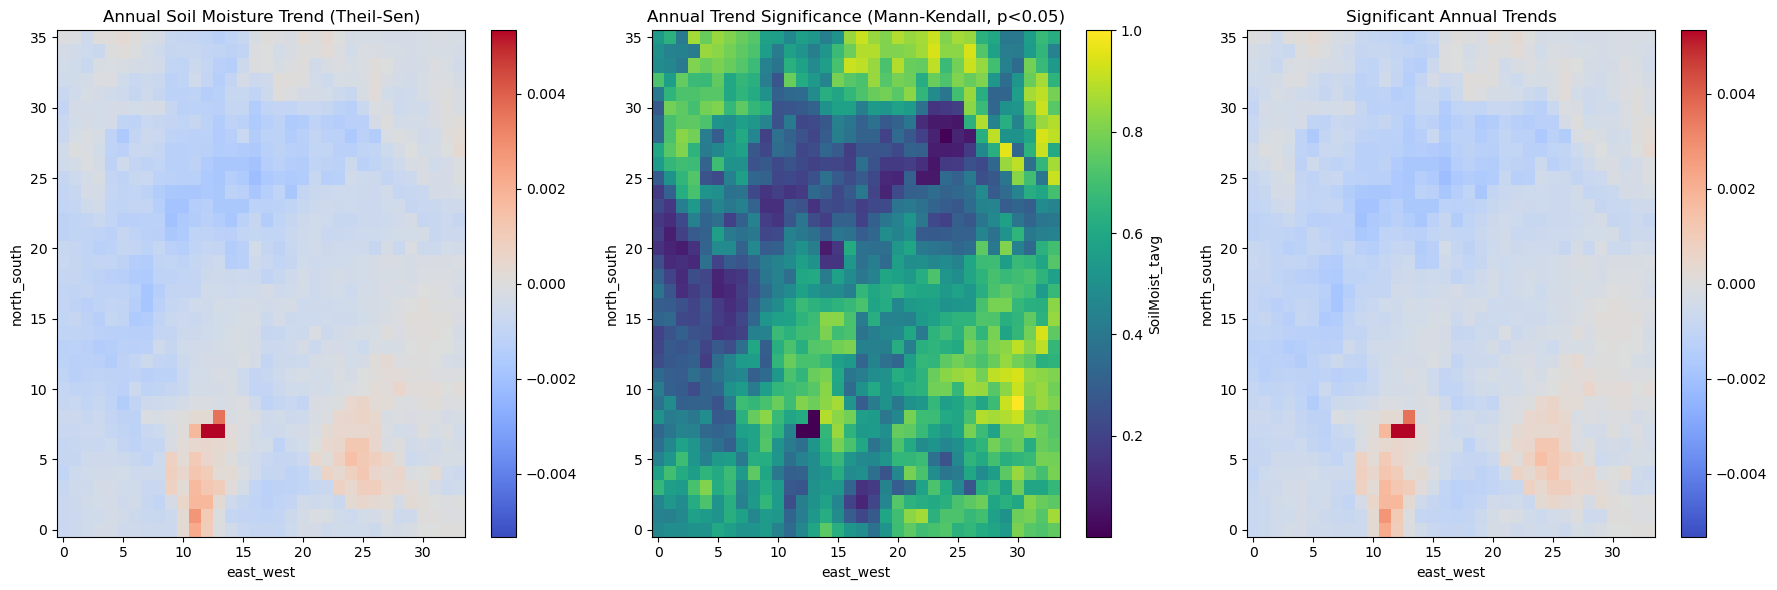

In [56]:
#Visualization of the trends and significance
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot the annual trend and significance
annual_trend.mean(dim="SoilMoist_profiles").plot(ax=ax[0], cmap='coolwarm')
ax[0].set_title('Annual Soil Moisture Trend (Theil-Sen)')

annual_significance.mean(dim="SoilMoist_profiles").plot(ax=ax[1], cmap='viridis')
ax[1].set_title('Annual Trend Significance (Mann-Kendall, p<0.05)')

# Overlay trend and significance for combined visualization (Example for annual data)
annual_combined = annual_trend.where(annual_significance)  # Mask non-significant trends
annual_combined.mean(dim="SoilMoist_profiles").plot(ax=ax[2], cmap='coolwarm')
ax[2].set_title('Significant Annual Trends')

plt.tight_layout()
plt.show()

In [ ]:

#Aggregation: The resample function is used to calculate monthly, seasonal, and annual means of the soil moisture data.

#Theil–Sen Regression: The calculate_theil_sen_trend function uses scipy.stats.theilslopes to compute the robust slope of the trend for each grid cell.

#Mann–Kendall Test: The mann_kendall_test function utilizes pymannkendall to test the statistical significance of the trends. 
#Trends with p-values below 0.05 are considered significant.

#Visualization: Plots show trends, significance, and combined views to highlight significant trends spatially.

In [60]:
#Calculate the Long-Term Average Soil Moisture:

# Calculate linear trends in soil moisture values over time using linregress
trends = np.empty_like(long_term_average)  # Initialize an array for trends with the same shapeprint
print(trends.shape)

(36, 34)


In [62]:
yearly_averages = np.empty((len(years), combined_soil_moisture.shape[1], combined_soil_moisture.shape[2]))  # (years, north_south, east_west)
print(yearly_averages.shape)

(15, 36, 34)


In [64]:
for i, year in enumerate(years):
    year_mask = time_index.year == year
    yearly_averages[i, :, :] = combined_soil_moisture[year_mask, :, :].mean(axis=0)

In [66]:
from scipy.stats import linregress

for i in range(trends.shape[0]):  # Iterate over north_south
    for j in range(trends.shape[1]):  # Iterate over east_west
        # Extract the time series of yearly averages for each grid cell
        yearly_time_series = yearly_averages[:, i, j]
        
        # Perform linear regression to get the slope (trend) over years
        slope, intercept, r_value, p_value, std_err = linregress(years, yearly_time_series)
        
        # Store the slope as the trend
        trends[i, j] = slope

In [68]:
print(trends.max())
print(trends.mean())
print(trends.min())

0.007943338
-0.0007094821
-0.0024975936


In [213]:
np.linspace(-0.01, 0.01, 21)

array([-0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
       -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,
        0.006,  0.007,  0.008,  0.009,  0.01 ])

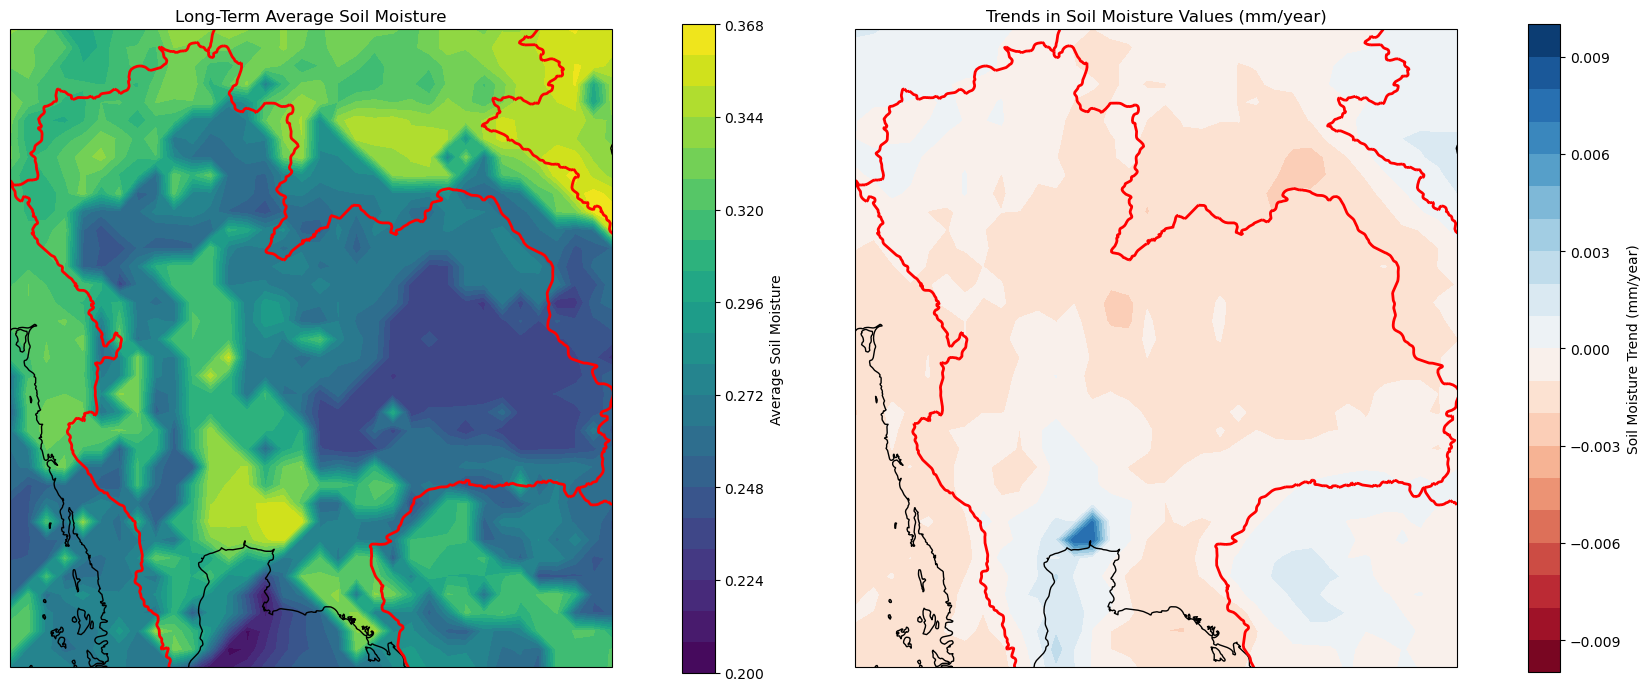

In [217]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot long-term average soil moisture (left)
ax1.set_title('Long-Term Average Soil Moisture')
contour1 = ax1.contourf(longitude_2D, latitude_2D, long_term_average, levels=20, cmap='viridis', transform=ccrs.PlateCarree())
ax1.set_extent([longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
cbar1 = fig.colorbar(contour1, ax=ax1, fraction=0.046, pad=0.1) #horientation='horizontal', 
cbar1.set_label('Average Soil Moisture')

# Plot trends in soil moisture values (right)
ax2.set_title('Trends in Soil Moisture Values (mm/year)')
contour2 = ax2.contourf(longitude_2D, latitude_2D, trends, levels=np.linspace(-0.01, 0.01, 21), cmap='RdBu', transform=ccrs.PlateCarree())
ax2.set_extent([longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
cbar2 = fig.colorbar(contour2, ax=ax2, fraction=0.046, pad=0.1) #horientation='horizontal', 
cbar2.set_label('Soil Moisture Trend (mm/year)')

plt.show()

In [70]:
# Find the indices of the maximum and minimum trends
max_trend_indices = np.unravel_index(np.argmax(trends), trends.shape)
min_trend_indices = np.unravel_index(np.argmin(trends), trends.shape)

print(f"Location with highest positive trend (increasing soil moisture): {max_trend_indices}, Trend: {trends[max_trend_indices]:.6f} mm/year")
print(f"Location with highest negative trend (decreasing soil moisture): {min_trend_indices}, Trend: {trends[min_trend_indices]:.6f} mm/year")

# Corresponding latitude and longitude
max_trend_lat, max_trend_lon = latitude_2D[max_trend_indices], longitude_2D[max_trend_indices]
min_trend_lat, min_trend_lon = latitude_2D[min_trend_indices], longitude_2D[min_trend_indices]

print(f"Coordinates of max positive trend: (Lat: {max_trend_lat}, Lon: {max_trend_lon})")
print(f"Coordinates of max negative trend: (Lat: {min_trend_lat}, Lon: {min_trend_lon})")

Location with highest positive trend (increasing soil moisture): (7, 12), Trend: 0.007943 mm/year
Location with highest negative trend (decreasing soil moisture): (27, 24), Trend: -0.002498 mm/year
Coordinates of max positive trend: (Lat: 13.625, Lon: 100.375)
Coordinates of max negative trend: (Lat: 18.625, Lon: 103.375)


In [72]:
#Visualize Trends for Specific Areas
# Extract time series for the max positive and negative trend locations
max_trend_series = yearly_averages[:, max_trend_indices[0], max_trend_indices[1]]
min_trend_series = yearly_averages[:, min_trend_indices[0], min_trend_indices[1]]

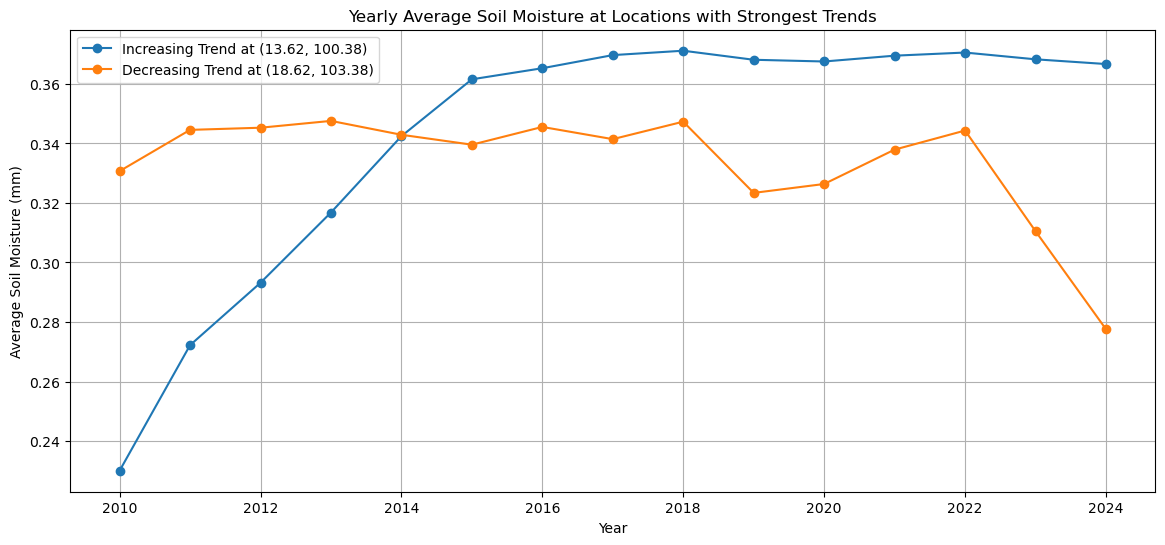

In [223]:
# Plotting the time series for both locations
plt.figure(figsize=(14, 6))

plt.plot(years, max_trend_series, label=f'Increasing Trend at ({max_trend_lat:.2f}, {max_trend_lon:.2f})', marker='o')
plt.plot(years, min_trend_series, label=f'Decreasing Trend at ({min_trend_lat:.2f}, {min_trend_lon:.2f})', marker='o')

plt.title('Yearly Average Soil Moisture at Locations with Strongest Trends')
plt.xlabel('Year')
plt.ylabel('Average Soil Moisture (mm)')
plt.legend()
plt.grid(True)
plt.show()

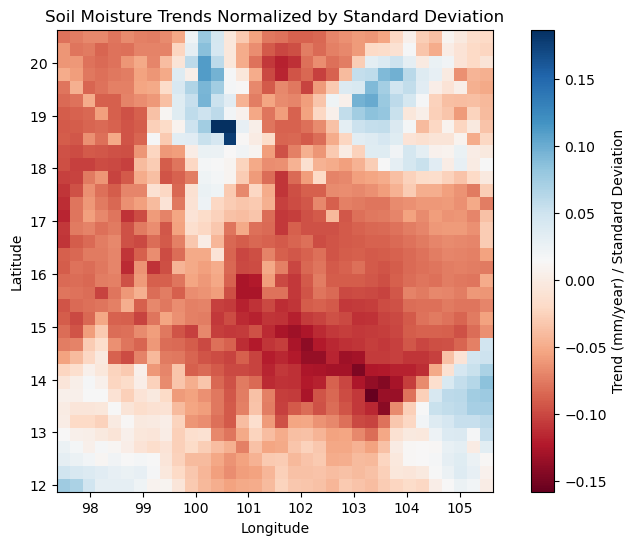

In [225]:
#Plotting Trends with Standard Deviations
# Calculate standard deviation of yearly averages for each grid cell
std_dev = yearly_averages.std(axis=0)

# Normalize trends by standard deviation
normalized_trends = trends / std_dev

# Plot normalized trends
plt.figure(figsize=(10, 6))
plt.imshow(normalized_trends, cmap='RdBu', extent=(longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()))
plt.colorbar(label='Trend (mm/year) / Standard Deviation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title('Soil Moisture Trends Normalized by Standard Deviation')
plt.show()

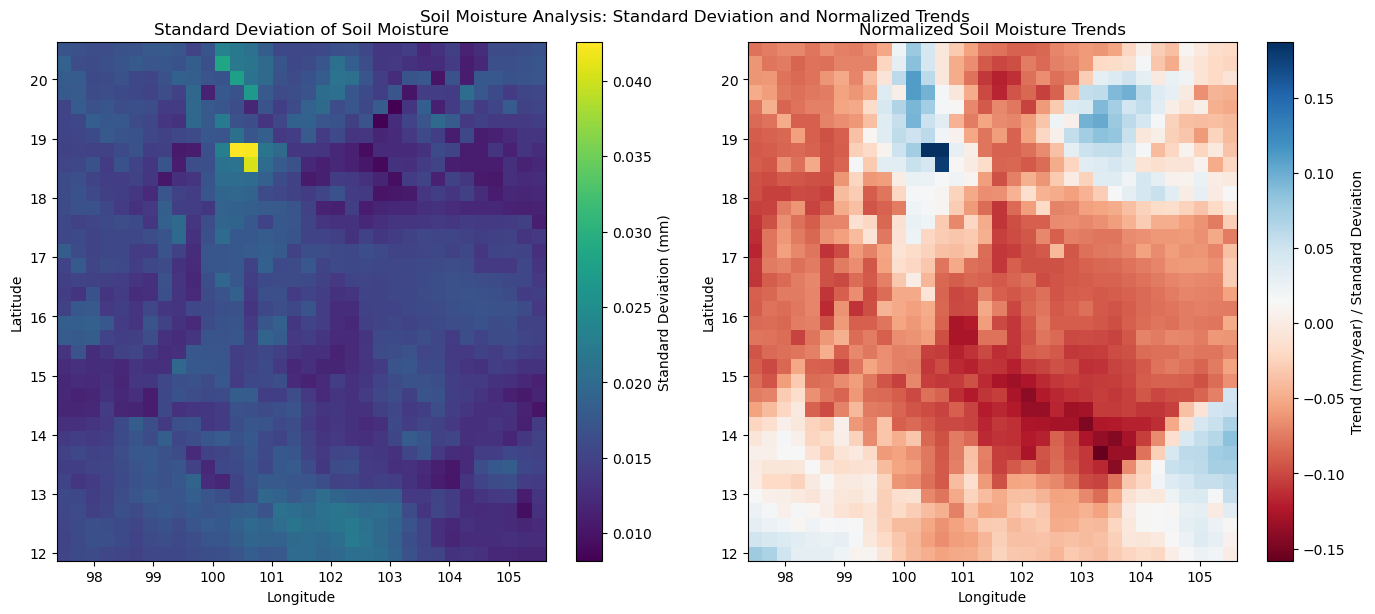

In [227]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Standard Deviation
std_plot = ax1.imshow(std_dev, cmap='viridis', 
                      extent=(longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()))
ax1.set_title('Standard Deviation of Soil Moisture')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(std_plot, ax=ax1, label='Standard Deviation (mm)')

# Plot Normalized Trends
trend_plot = ax2.imshow(normalized_trends, cmap='RdBu', 
                        extent=(longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()))
ax2.set_title('Normalized Soil Moisture Trends')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(trend_plot, ax=ax2, label='Trend (mm/year) / Standard Deviation')

plt.suptitle('Soil Moisture Analysis: Standard Deviation and Normalized Trends')
plt.tight_layout()
plt.show()

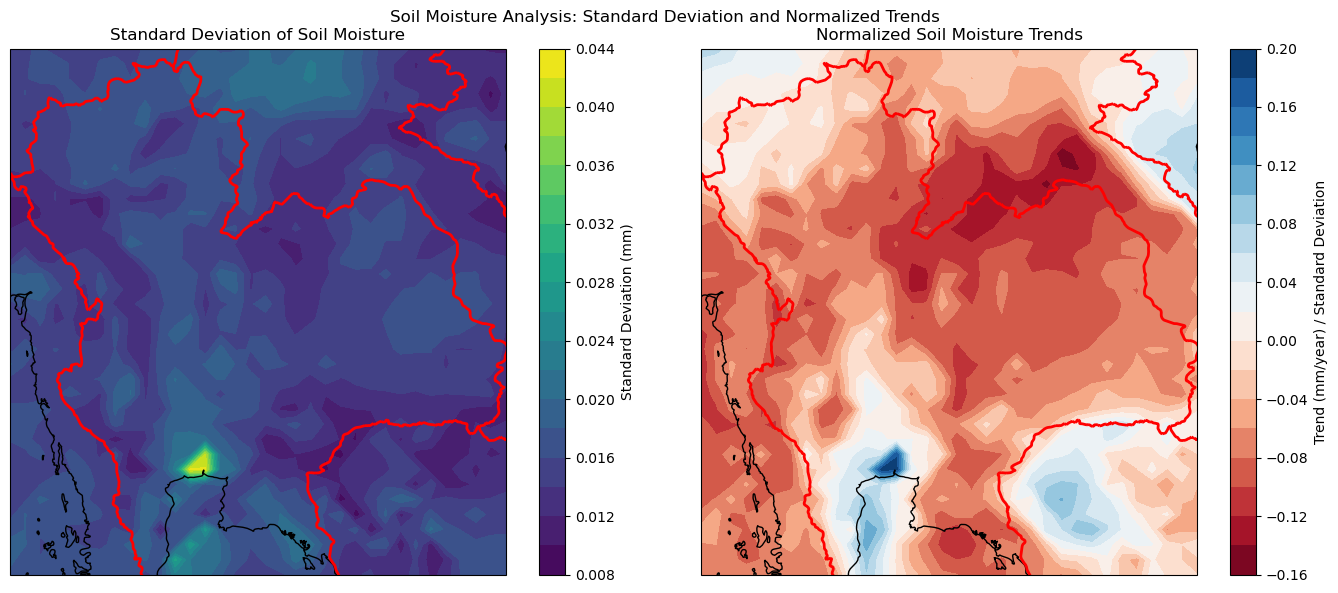

In [229]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot Standard Deviation
std_plot = ax1.contourf(longitude_2D, latitude_2D, std_dev, 20, cmap='viridis', transform=ccrs.PlateCarree())
ax1.set_title('Standard Deviation of Soil Moisture')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
plt.colorbar(std_plot, ax=ax1, orientation='vertical', label='Standard Deviation (mm)')

# Plot Normalized Trends
trend_plot = ax2.contourf(longitude_2D, latitude_2D, normalized_trends, 20, cmap='RdBu', transform=ccrs.PlateCarree())
ax2.set_title('Normalized Soil Moisture Trends')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
plt.colorbar(trend_plot, ax=ax2, orientation='vertical', label='Trend (mm/year) / Standard Deviation')

plt.suptitle('Soil Moisture Analysis: Standard Deviation and Normalized Trends')
plt.tight_layout()
plt.show()

In [74]:
yearly_averages.shape  

(15, 36, 34)

In [76]:
#compute the SSI and integrate it into a decision support
#1. Calculate the long-term average and standard deviation of soil moisture
long_term_mean = np.mean(yearly_averages, axis=0)  # Mean across years for each grid cell
long_term_std = np.std(yearly_averages, axis=0) 

In [78]:
# 2. Compute anomalies for each year by subtracting the long-term average
anomalies = yearly_averages - long_term_mean  # Anomalies for each year

In [80]:
# 3. Standardize anomalies to compute SSI
ssi = anomalies / long_term_std

In [82]:
ssi.shape

(15, 36, 34)

In [84]:
def classify_drought(ssi_array):
    """
    Classifies drought based on the Standardized Streamflow Index (SSI) values.

    Parameters:
        ssi_array (np.ndarray): 3D array of SSI values (e.g., time, north_south, east_west).

    Returns:
        np.ndarray: 3D array with drought categories corresponding to the SSI values.
    """
    # Create an empty array for drought classification with the same shape as ssi_array
    drought_classification = np.empty_like(ssi_array, dtype=np.int8)

    # Classification rules
    drought_classification[ssi_array <= -2.0] = -4  # Extreme Drought
    drought_classification[(ssi_array > -2.0) & (ssi_array <= -1.5)] = -3  # Severe Drought
    drought_classification[(ssi_array > -1.5) & (ssi_array <= -1.0)] = -2  # Moderate Drought
    drought_classification[(ssi_array > -1.0) & (ssi_array <= -0.5)] = -1  # Mild Drought
    drought_classification[(ssi_array > -0.5) & (ssi_array < 0.5)] = 0  # Near Normal
    drought_classification[(ssi_array >= 0.5) & (ssi_array < 1.0)] = 1  # Moderately Wet
    drought_classification[(ssi_array >= 1.0) & (ssi_array < 1.5)] = 2  # Severely Wet
    drought_classification[ssi_array >= 1.5] = 3  # Extremely Wet

    return drought_classification

In [86]:
# Classify drought conditions based on SSI values
drought_categories = classify_drought(ssi)
print(drought_categories.shape)

(15, 36, 34)


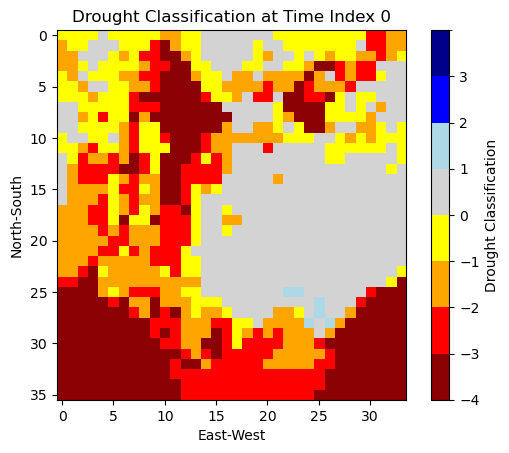

In [88]:
import matplotlib.colors as mcolors

# Define a color map and boundaries for drought classification
cmap = mcolors.ListedColormap(['darkred', 'red', 'orange', 'yellow', 'lightgrey', 
                               'lightblue', 'blue', 'darkblue'])
bounds = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Select a specific time index to visualize (e.g., index 0)
time_index = 0
drought_slice = drought_categories[time_index]

# Plotting the drought classification
plt.figure()
plt.imshow(drought_slice, cmap=cmap, norm=norm)
plt.colorbar(ticks=[-4, -3, -2, -1, 0, 1, 2, 3], label='Drought Classification')
plt.title(f'Drought Classification at Time Index {time_index}')
plt.xlabel('East-West')
plt.ylabel('North-South')
plt.xticks(np.arange(0, drought_slice.shape[1], 5))
plt.yticks(np.arange(0, drought_slice.shape[0], 5))
plt.grid(False)
plt.show()

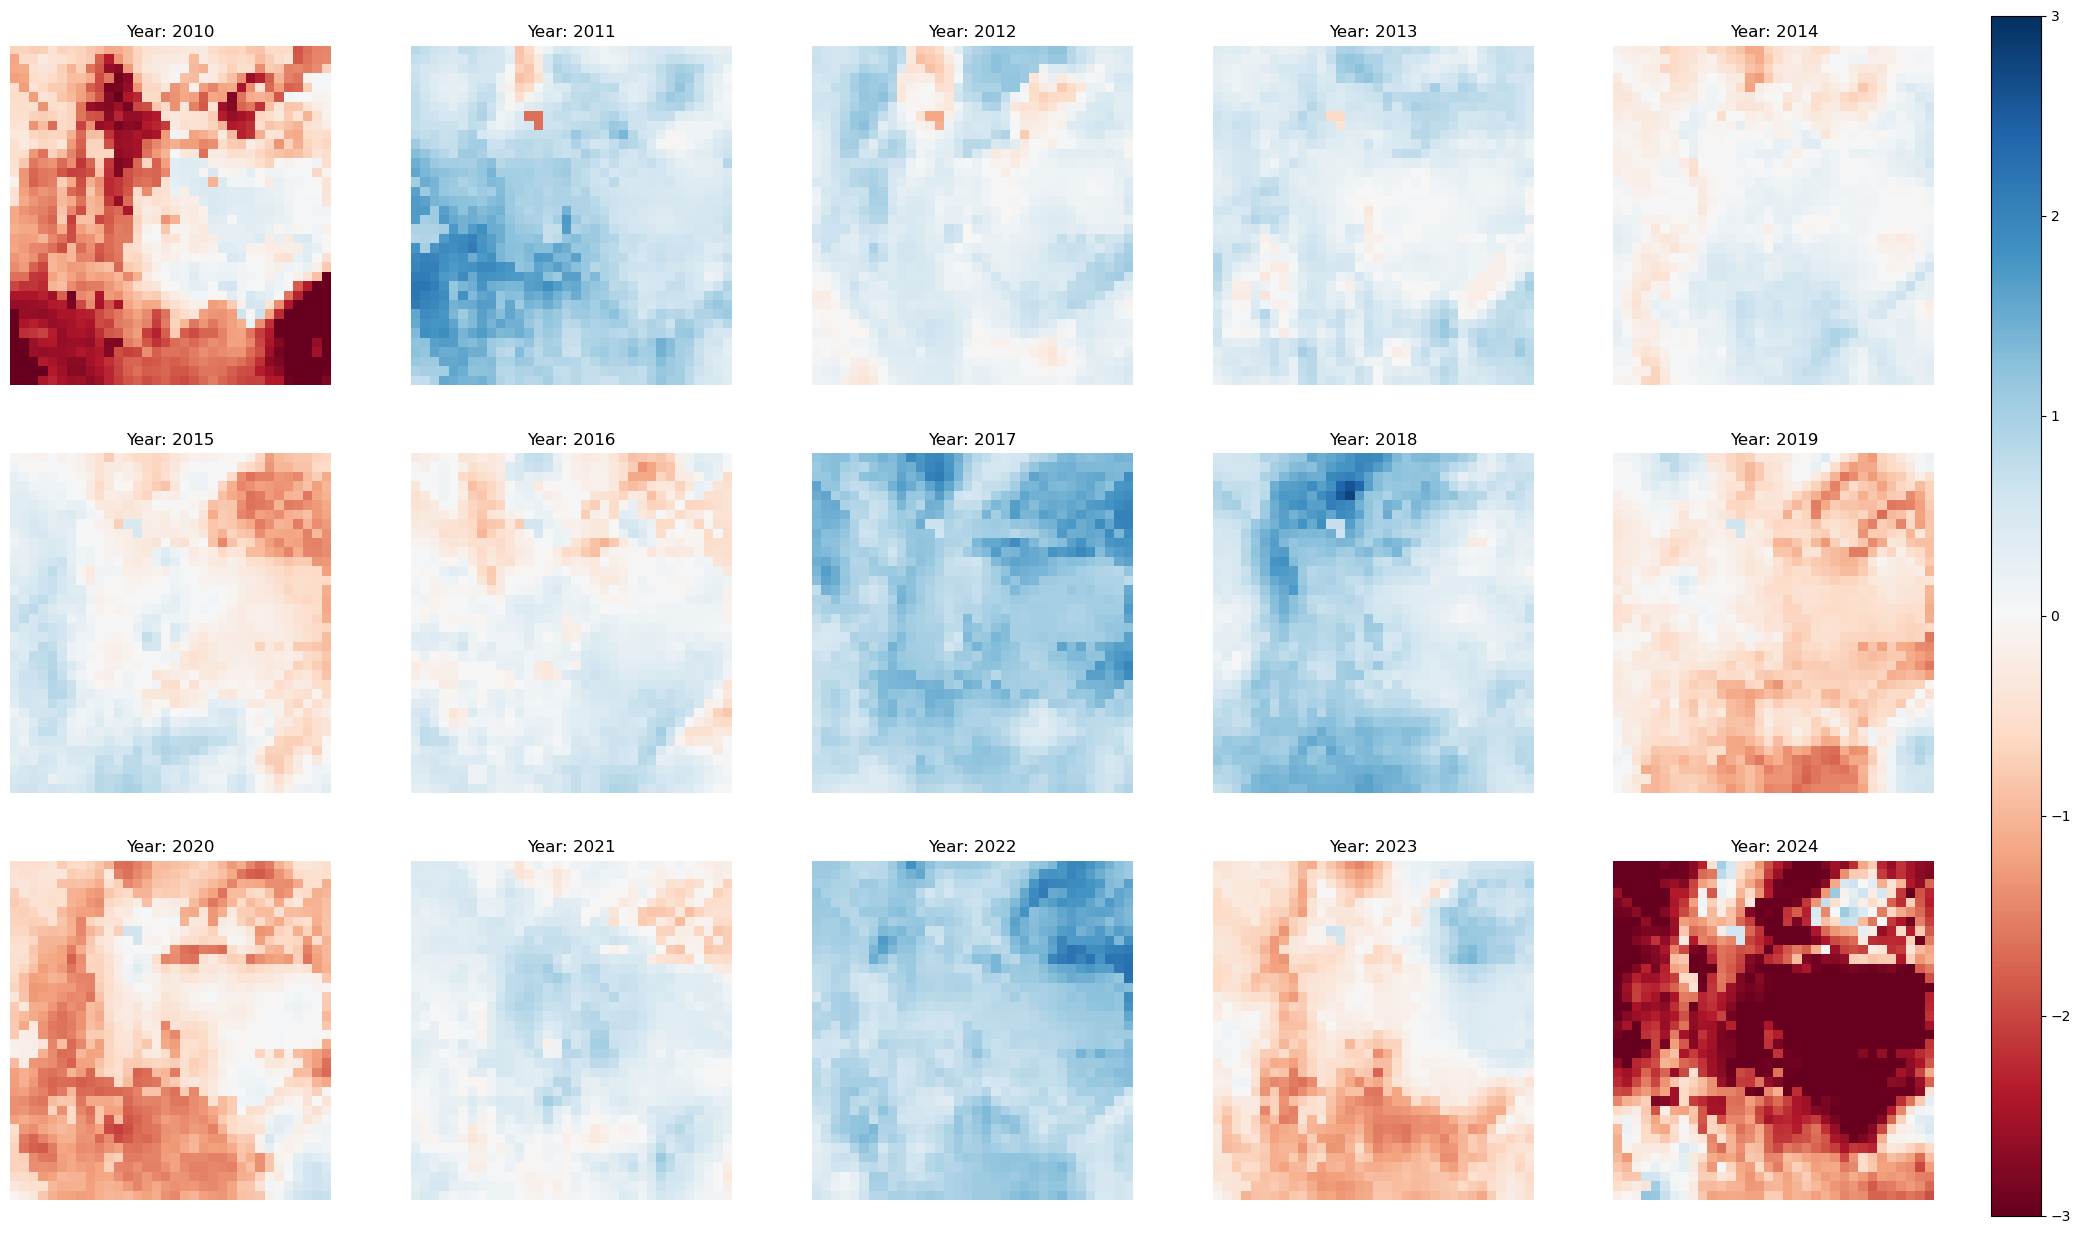

In [304]:
# Define the number of years and the shape of spatial dimensions
num_years = ssi.shape[0]
north_south, east_west = ssi.shape[1], ssi.shape[2]

# Plot each year's SSI data
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), sharex=True, sharey=True)

axes = axes.flatten()
num_plots = len(axes)

# Plot each year's SSI data
for i in range(num_plots):
    if i < ssi.shape[0]:
        ax = axes[i]
        im = ax.imshow(ssi[i, :, :], cmap='RdBu', vmin=-3, vmax=3)
        ax.set_title(f'Year: {year+i}')
        ax.axis('off')

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical')

# Adjust layout
plt.show()

In [66]:
# Example histogram
plt.hist(ssi.flatten(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of SSI Values')
plt.xlabel('SSI Value')
plt.ylabel('Frequency')
plt.show()

In [90]:
# Flatten the SSI data for easier analysis
ssi_flat = ssi.flatten()

# Get basic statistics
mean_ssi = np.mean(ssi_flat)
std_ssi = np.std(ssi_flat)
min_ssi = np.min(ssi_flat)
max_ssi = np.max(ssi_flat)

print(f"Mean SSI: {mean_ssi}")
print(f"Standard Deviation of SSI: {std_ssi}")
print(f"Min SSI: {min_ssi}")
print(f"Max SSI: {max_ssi}")

Mean SSI: -4.953674846257779e-17
Standard Deviation of SSI: 1.0
Min SSI: -3.5711723746524706
Max SSI: 2.7811136079541785


In [132]:
years[0]

2010

In [160]:
t_index = 0

In [176]:
print(ssi.max())
print(ssi.min())

2.7811136079541785
-3.5711723746524706


In [178]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot SSI
ssi_plot = ax.imshow(
    ssi[t_index, :, :], 
    cmap='RdBu', 
    extent=(longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()), 
    transform=ccrs.PlateCarree(), vmin=-4, vmax=3
)
ax.set_title(f'Standardized Soil Moisture Index (SSI) for Year {years[t_index]}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add Cartopy features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')

# Add colorbar
plt.colorbar(ssi_plot, ax=ax, orientation='vertical', label='SSI')

plt.show()

In [112]:
time_index

DatetimeIndex(['2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05',
               '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09',
               '2010-01-10', '2010-01-11',
               ...
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2023-12-31', '2024-01-01'],
              dtype='datetime64[ns]', length=5113, freq=None)

In [148]:
num_years = ssi.shape[0]

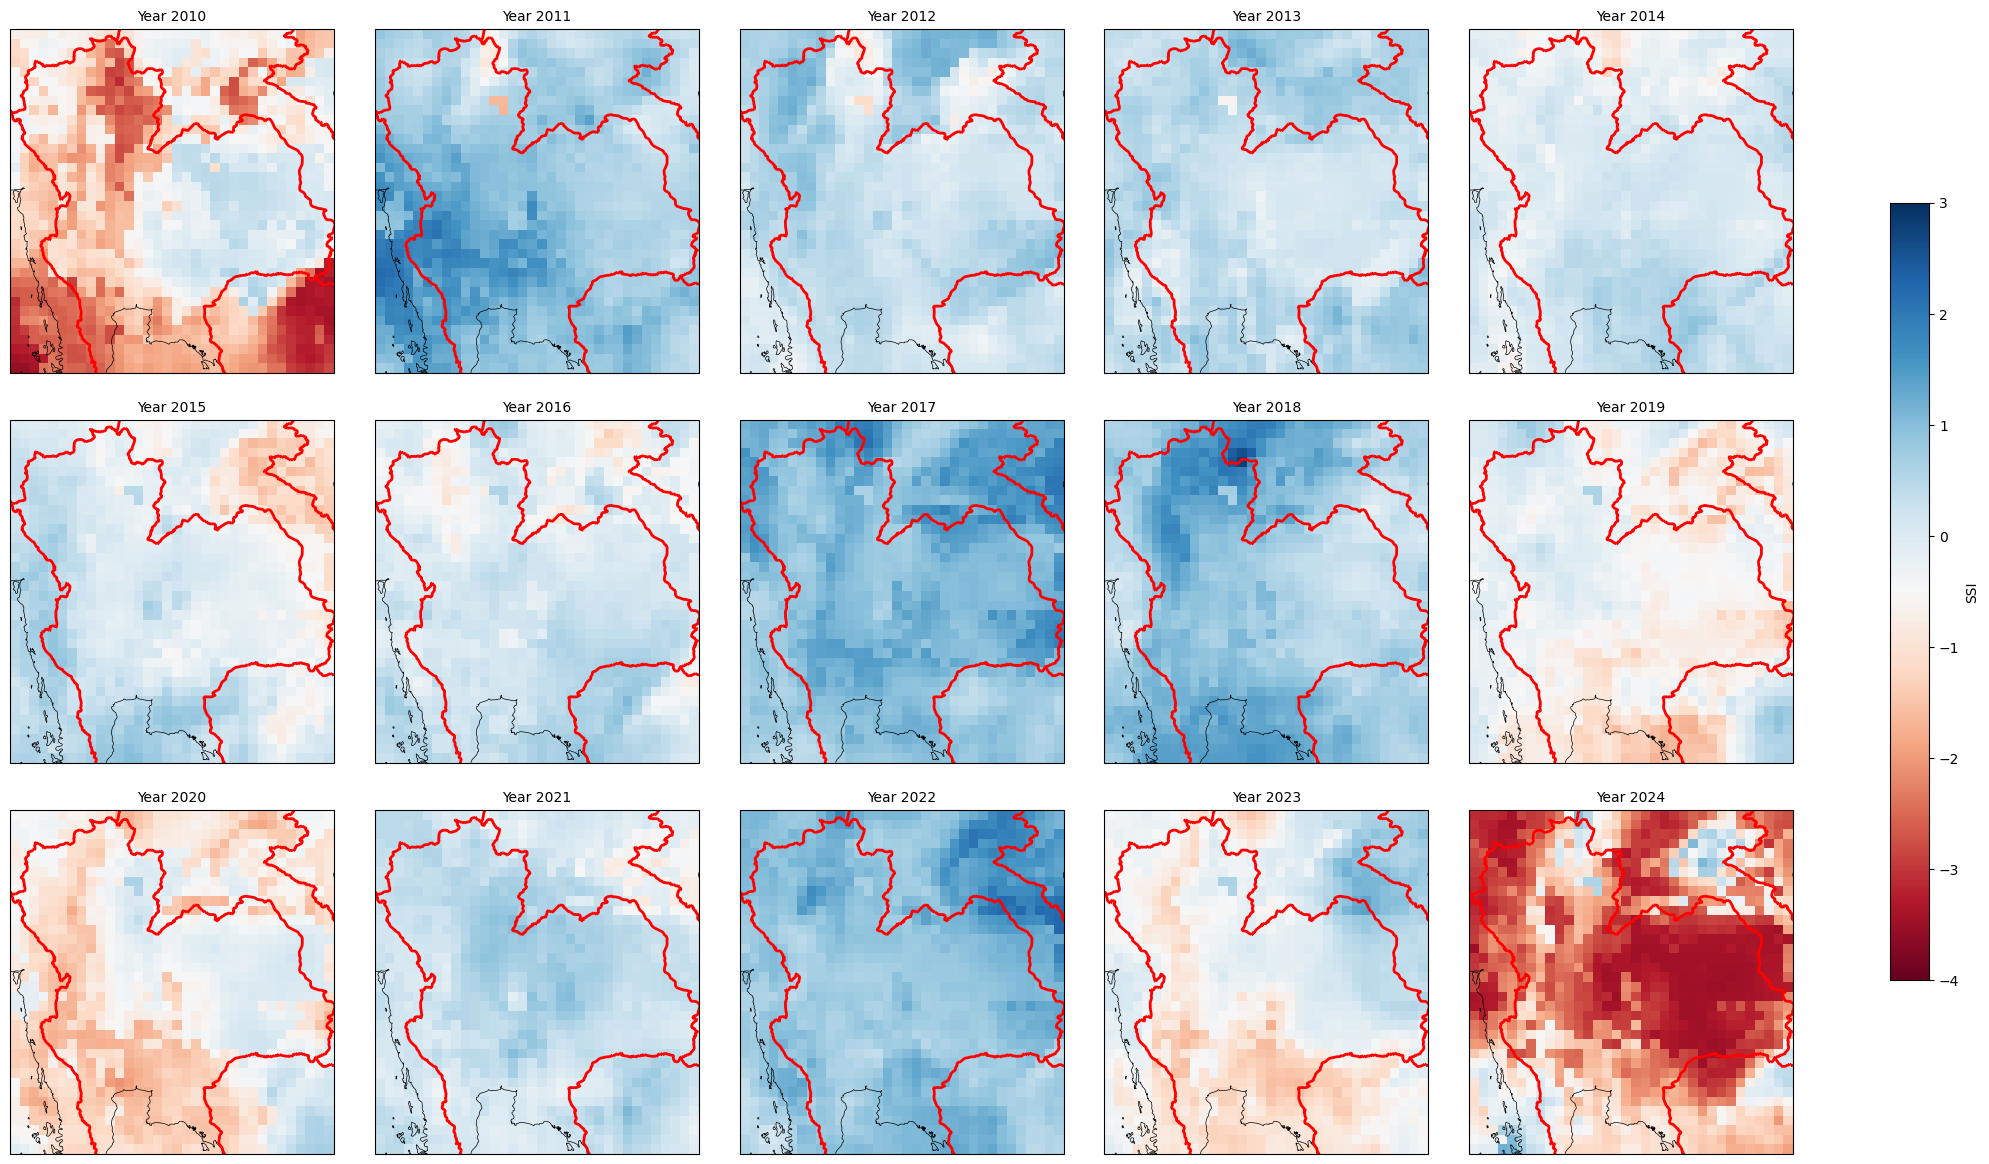

In [180]:
# Create the figure and axes with the required number of subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over each year and corresponding subplot axis
for t_index, ax in enumerate(axes[:num_years]):
    # Plot SSI for the current year
    ssi_plot = ax.imshow(
        ssi[t_index, :, :], 
        cmap='RdBu', 
        extent=(longitude_2D.min(), longitude_2D.max(), latitude_2D.min(), latitude_2D.max()), 
        transform=ccrs.PlateCarree(), vmin=-4, vmax=3
    )
    
    # Set the title for each subplot
    ax.set_title(f'Year {years[t_index]}', fontsize=10)
    
    # Add Cartopy features for context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')

# Remove any unused axes if the subplot grid is larger than the data
for ax in axes[num_years:]:
    fig.delaxes(ax)

# Adjust layout and add a colorbar for the entire figure
fig.tight_layout(pad=2.0)
cbar = fig.colorbar(ssi_plot, ax=axes, orientation='vertical', fraction=0.02, pad=0.05, label='SSI')

plt.show()

In [143]:
# Convert xarray to numpy arrays
soil_moisture_val = ds_surface['SoilMoist_tavg'].values  # (5113, 4, 36, 34)
print(soil_moisture_val.shape)

(5113, 4, 36, 34)


In [145]:
#Decision Support Using a Drought Index
# Calculate the mean and standard deviation over time for normalization
mean_sm = np.mean(soil_moisture_val, axis=0)  # Average soil moisture for each grid cell
std_sm = np.std(soil_moisture_val, axis=0)    # Standard deviation for each grid cell

In [147]:
# Compute standardized soil moisture (Z-score) for the last available time step (e.g., end of 2023)
current_sm_1 = soil_moisture_val[-1, 0, :, :]  # first soil layer

In [149]:
z_score = (current_sm_1 - mean_sm[0, :, :]) / std_sm[0, :, :] #example

In [151]:
# Define drought levels based on Z-scores
# (e.g., drought if Z-score is less than -1)
drought_index = np.zeros_like(z_score)
drought_index[z_score < -1] = 1  # Potential risk
drought_index[z_score < -2] = 2  # High danger

In [153]:
# Calculate the long-term mean soil moisture across time steps
current_sm = np.mean(soil_moisture_val, axis=0)  # Shape: (SoilMoist_profiles, north_south, east_west)

# average across soil layers as well, use:
current_sm = np.mean(current_sm, axis=0)  # Shape: (north_south, east_west)

In [157]:
z_score_mean = (current_sm - mean_sm[0, :, :]) / std_sm[0, :, :] # mean

In [159]:
# Check the min, max, and mean of Z-scores
print("Z-Score Stats:")
print(f"Min: {np.min(z_score_mean)}")
print(f"Max: {np.max(z_score_mean)}")
print(f"Mean: {np.mean(z_score_mean)}")

Z-Score Stats:
Min: -0.4794248938560486
Max: 0.4500669836997986
Mean: 0.09847315400838852


In [161]:
# 1 _ Use Percentiles Instead of Z-Scores
# Calculate percentiles of current soil moisture
percentile_20 = np.percentile(current_sm, 20)
percentile_10 = np.percentile(current_sm, 10)

# Define drought levels using percentiles
drought_index_mean = np.zeros_like(current_sm)
drought_index_mean[current_sm < percentile_20] = 1  # Potential risk (below 20th percentile)
drought_index_mean[current_sm < percentile_10] = 2  # High danger (below 10th percentile)

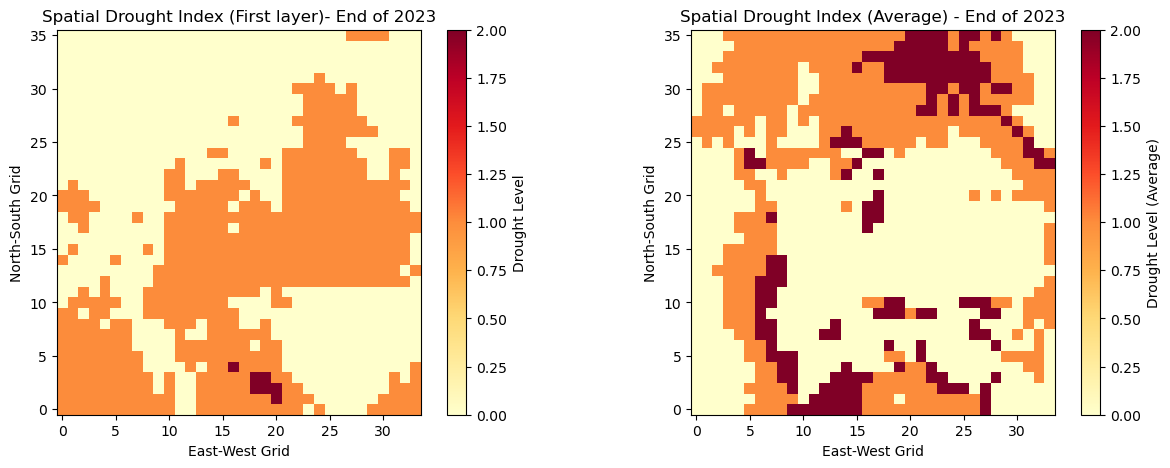

In [171]:
# Plot the spatial drought index
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(drought_index, cmap='YlOrRd', origin='lower')
plt.colorbar(label='Drought Level')
plt.title('Spatial Drought Index (First layer)- End of 2023')
plt.xlabel('East-West Grid')
plt.ylabel('North-South Grid')
plt.xticks(ticks=np.arange(0, soil_moisture.shape[3], 5))
plt.yticks(ticks=np.arange(0, soil_moisture.shape[2], 5))

plt.subplot(1, 2, 2)
plt.imshow(drought_index_mean, cmap='YlOrRd', origin='lower')
plt.colorbar(label='Drought Level (Average)')
plt.title('Spatial Drought Index (Average) - End of 2023')
plt.xlabel('East-West Grid')
plt.ylabel('North-South Grid')
plt.xticks(ticks=np.arange(0, soil_moisture.shape[3], 5))
plt.yticks(ticks=np.arange(0, soil_moisture.shape[2], 5))

plt.show()

In [167]:
# 2 _ Thresholds based on the mean and standard deviation of Z-scores dynamically
# Calculate mean and standard deviation of Z-scores
mean_z = np.mean(z_score_mean)
std_z = np.std(z_score_mean)

# Dynamic thresholds based on current distribution
drought_index_mean = np.zeros_like(z_score_mean)
drought_index_mean[z_score_mean < (mean_z - 0.5 * std_z)] = 1  # Potential risk
drought_index_mean[z_score_mean < (mean_z - 1 * std_z)] = 2    # High danger

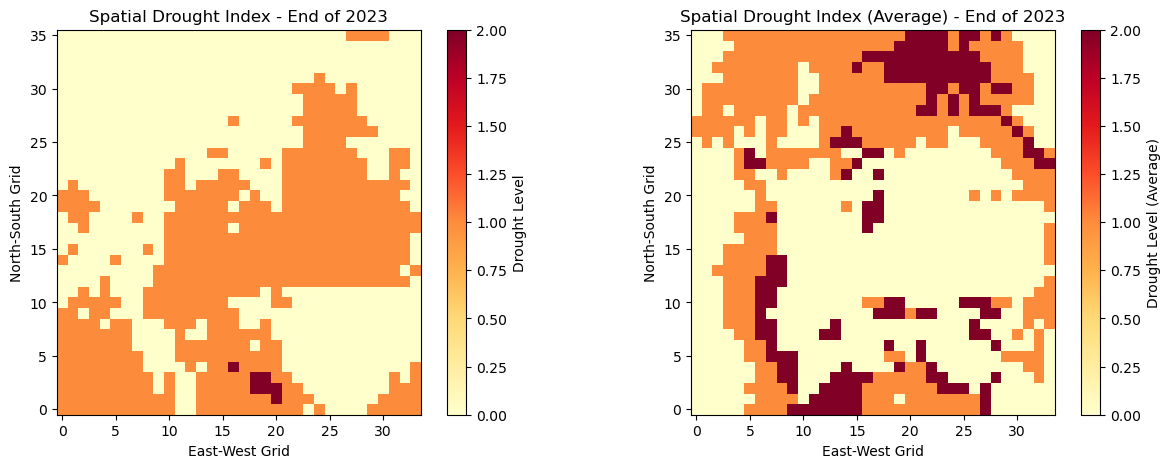

In [173]:
# Plot the spatial drought index
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(drought_index, cmap='YlOrRd', origin='lower')
plt.colorbar(label='Drought Level')
plt.title('Spatial Drought Index - End of 2023')
plt.xlabel('East-West Grid')
plt.ylabel('North-South Grid')
plt.xticks(ticks=np.arange(0, soil_moisture.shape[3], 5))
plt.yticks(ticks=np.arange(0, soil_moisture.shape[2], 5))

plt.subplot(1, 2, 2)
plt.imshow(drought_index_mean, cmap='YlOrRd', origin='lower')
plt.colorbar(label='Drought Level (Average)')
plt.title('Spatial Drought Index (Average) - End of 2023')
plt.xlabel('East-West Grid')
plt.ylabel('North-South Grid')
plt.xticks(ticks=np.arange(0, soil_moisture.shape[3], 5))
plt.yticks(ticks=np.arange(0, soil_moisture.shape[2], 5))

plt.show()

In [175]:
# Plot the spatial drought index with projection
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Spatial Drought Index - End of 2023
im1 = ax[0].imshow(drought_index, cmap='YlOrRd', origin='lower', transform=ccrs.PlateCarree())
#ax[0].coastlines()
ax[0].add_feature(cfeature.COASTLINE)
ax[0].add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
ax[0].add_feature(cfeature.RIVERS, linestyle='--', alpha=0.5)
ax[0].set_title('Spatial Drought Index - End of 2023')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
fig.colorbar(im1, ax=ax[0], label='Drought Level')

# Plot 2: Spatial Drought Index (Average) - End of 2023
im2 = ax[1].imshow(drought_index_mean, cmap='YlOrRd', origin='lower', transform=ccrs.PlateCarree())
ax[1].add_feature(cfeature.COASTLINE)
ax[1].add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='red')
ax[1].add_feature(cfeature.RIVERS, linestyle='--', alpha=0.5)
ax[1].set_title('Spatial Drought Index (Average) - End of 2023')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
fig.colorbar(im2, ax=ax[1], label='Drought Level (Average)')


# Display gridlines
for a in ax:
    a.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.tight_layout()
plt.show()

In [177]:
# 1.Standardize Soil Moisture data
soil_moist = ds_surface['SoilMoist_tavg'].mean(dim='SoilMoist_profiles')  # Averaging over profiles
soil_moist_anomaly = (soil_moist - soil_moist.mean(dim='time')) / soil_moist.std(dim='time')

In [179]:
#Trend Analysis using Mann-Kendall Test and Linear Regression
def calculate_trend(data):
    """Calculate the trend using linear regression."""
    x = np.arange(len(data))
    slope, intercept, r_value, p_value, std_err = linregress(x, data)
    return slope, p_value

In [183]:
# Apply the trend function spatially with dask="parallelized" and allow rechunking
trend_slope = xr.apply_ufunc(
    calculate_trend,
    soil_moist_anomaly,
    input_core_dims=[["time"]],
    output_core_dims=[[], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float],
    dask_gufunc_kwargs={"allow_rechunk": True},  # Allow rechunking, use with caution
)

In [185]:
# Split trend_slope into separate arrays for slope and p-values
slope, p_values = trend_slope[0], trend_slope[1]

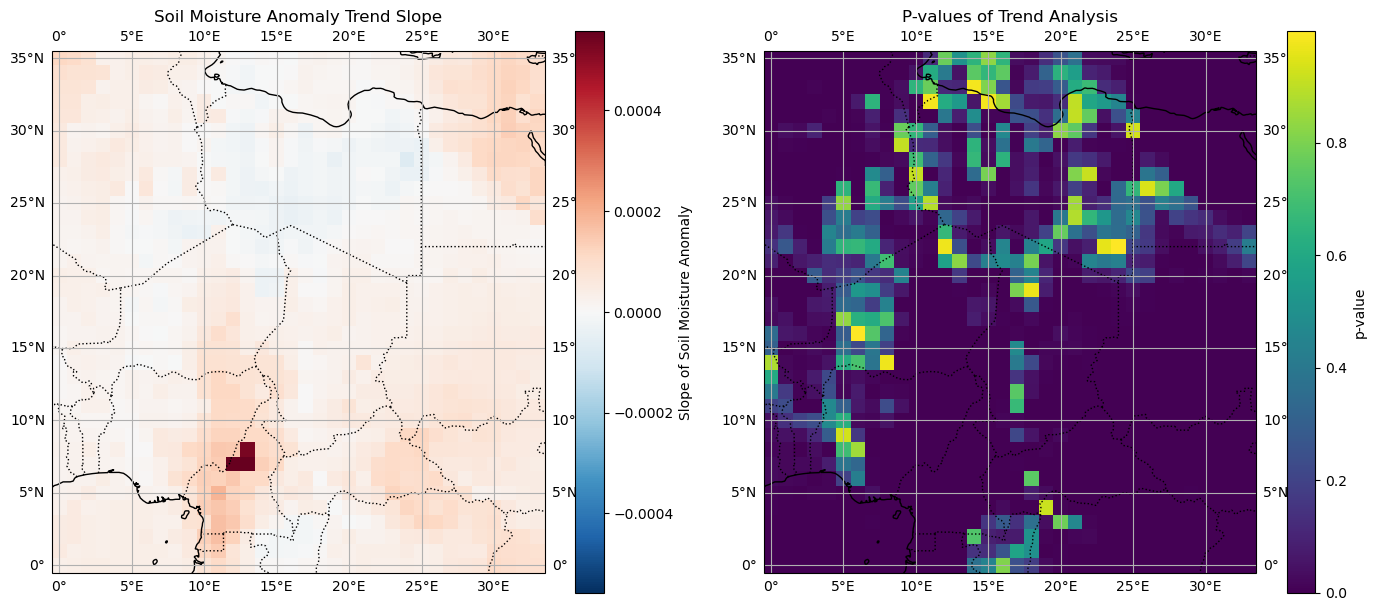

In [187]:
#Visualize Spatiotemporal Changes
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Plotting the slope (trend strength)
slope.plot(ax=ax[0], cmap="RdBu_r", cbar_kwargs={"label": "Slope of Soil Moisture Anomaly"})
ax[0].coastlines()
ax[0].set_title('Soil Moisture Anomaly Trend Slope')

# Plotting the p-values to identify significant trends
p_values.plot(ax=ax[1], cmap="viridis", cbar_kwargs={"label": "p-value"})
ax[1].coastlines()
ax[1].set_title('P-values of Trend Analysis')

# Adding gridlines and features for better visualization
for a in ax:
    a.add_feature(cfeature.BORDERS, linestyle=':')
    a.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.tight_layout()
plt.show()

In [ ]:
#Drought Index: The script uses soil moisture anomalies to represent drought conditions. 

#Trend Calculation: Linear regression is used to estimate the slope of soil moisture anomalies over time, indicating long-term trends. 
#The Mann-Kendall test provides p-values, highlighting statistically significant trends.

#Visualization: The script uses cartopy for visualizing the spatial distribution of trends and p-values. 
#Customize the visualization to better suit needs.

#Statistical Significance: Significant p-values (e.g., p < 0.05) highlight areas with notable trends in drought conditions.

In [34]:
import numpy as np

# Extract and convert variables from ds_surface
soil_moist_tavg = ds_surface['SoilMoist_tavg'].values  # Shape: (time, SoilMoist_profiles, north_south, east_west)
tws_tavg = ds_surface['TWS_tavg'].values  # Shape: (time, north_south, east_west)
streamflow_tavg_surface = ds_surface['Streamflow_tavg'].values  # Shape: (time, north_south, east_west)
lat_surface = ds_surface['lat'].values  # Shape: (time, north_south, east_west)
lon_surface = ds_surface['lon'].values  # Shape: (time, north_south, east_west)

# Extract and convert variables from ds_routing
streamflow_tavg_routing = ds_routing['Streamflow_tavg'].values  # Shape: (time, north_south, east_west)
lat_routing = ds_routing['lat'].values  # Shape: (time, north_south, east_west)
lon_routing = ds_routing['lon'].values  # Shape: (time, north_south, east_west)

# Print the shapes of the converted arrays to confirm
print("Soil Moisture:", soil_moist_tavg.shape)
print("TWS:", tws_tavg.shape)
print("Streamflow (Surface):", streamflow_tavg_surface.shape)
print("Streamflow (Routing):", streamflow_tavg_routing.shape)
print("Lat (Surface):", lat_surface.shape)
print("Lon (Surface):", lon_surface.shape)
print("Lat (Routing):", lat_routing.shape)
print("Lon (Routing):", lon_routing.shape)

Soil Moisture: (5113, 4, 36, 34)
TWS: (5113, 36, 34)
Streamflow (Surface): (5113, 36, 34)
Streamflow (Routing): (5113, 36, 34)
Lat (Surface): (5113, 36, 34)
Lon (Surface): (5113, 36, 34)
Lat (Routing): (5113, 36, 34)
Lon (Routing): (5113, 36, 34)


In [36]:
# Flatten spatial dimensions to simplify trend computation (5113, 1224)
tws_flat = tws_tavg.reshape(tws_tavg.shape[0], -1)
soil_moisture_flat = soil_moist_tavg.reshape(soil_moist_tavg.shape[0], -1)
streamflow_flat = streamflow_tavg_surface.reshape(streamflow_tavg_surface.shape[0], -1)

streamflow_routing_flat = streamflow_tavg_routing.reshape(streamflow_tavg_routing.shape[0], -1)

In [50]:
# Time index (days since start) (5113,)
time_index_2 = np.arange(tws_tavg.shape[0])

In [44]:
from scipy.stats import linregress
# Define a function to compute trends in mm/year
def compute_trend(data, time_index):
    trends = np.full(data.shape[1], np.nan)  # Initialize trends array with NaN
    for i in range(data.shape[1]):
        y = data[:, i]
        if not np.isnan(y).all():  # Check if data is not all NaN
            slope, _, _, _, _ = linregress(time_index, y)
            trends[i] = slope * 365.25  # Convert slope to per year
    return trends

In [52]:
# Compute trends for each variable
tws_trend = compute_trend(tws_flat, time_index_2) #(1224,)
soil_moisture_trend = compute_trend(soil_moisture_flat, time_index_2) #(4896,)
streamflow_trend = compute_trend(streamflow_flat, time_index_2) #(1224,)

streamflow_routing_trend = compute_trend(streamflow_routing_flat, time_index_2) #(1224,)

In [54]:
# Reshape back to spatial dimensions for visualization
tws_trend_reshaped = tws_trend.reshape(36, 34)
soil_moisture_trend_reshaped = soil_moisture_trend.reshape(4, 36, 34)
streamflow_trend_reshaped = streamflow_trend.reshape(36, 34)

streamflow_routing_trend_reshaped = streamflow_routing_trend.reshape(36, 34)

print(tws_trend_reshaped.shape)
print(soil_moisture_trend_reshaped.shape)
print(streamflow_trend_reshaped.shape)
print(streamflow_routing_trend_reshaped.shape)

(36, 34)
(4, 36, 34)
(36, 34)
(36, 34)


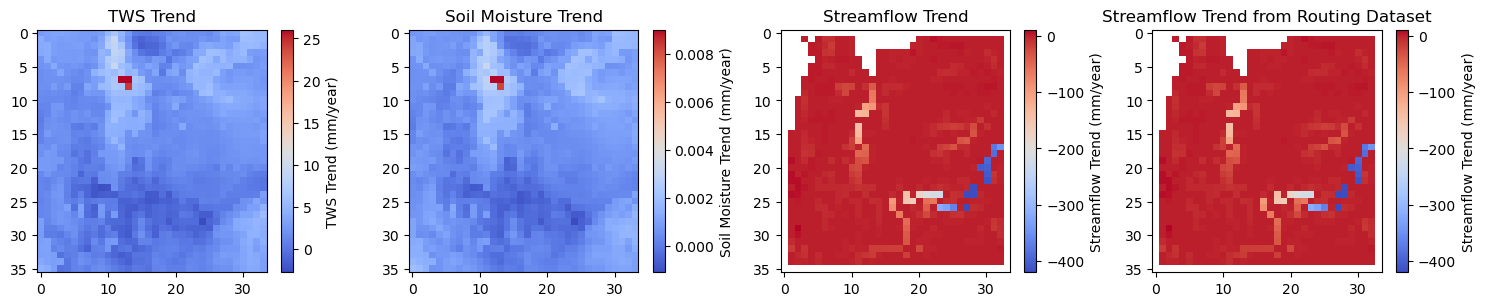

In [56]:
# Display trends using matplotlib
plt.figure(figsize=(15, 3))
plt.subplot(1, 4, 1)
plt.imshow(tws_trend_reshaped, cmap='coolwarm')
plt.colorbar(label='TWS Trend (mm/year)')
plt.title('TWS Trend')

plt.subplot(1, 4, 2)
plt.imshow(np.nanmean(soil_moisture_trend_reshaped, axis=0), cmap='coolwarm')
plt.colorbar(label='Soil Moisture Trend (mm/year)')
plt.title('Soil Moisture Trend')

plt.subplot(1, 4, 3)
plt.imshow(streamflow_trend_reshaped, cmap='coolwarm')
plt.colorbar(label='Streamflow Trend (mm/year)')
plt.title('Streamflow Trend')

# Display streamflow routing trends using matplotlib
plt.subplot(1, 4, 4)
plt.imshow(streamflow_routing_trend_reshaped, cmap='coolwarm')
plt.colorbar(label='Streamflow Trend (mm/year)')
plt.title('Streamflow Trend from Routing Dataset')
#plt.xlabel('Longitude Grid')
#plt.ylabel('Latitude Grid')

plt.tight_layout()
plt.show()

In [58]:
# Calculate mean over soil moisture layers
soil_moisture_trend_mean = np.nanmean(soil_moisture_trend_reshaped, axis=0)  # Shape should be (36, 34)
soil_moisture_trend_mean.shape

(36, 34)

In [60]:
# Plotting
# Set up the figure and subplots with Cartopy's PlateCarree projection
fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot TWS Trend
im1 = axes[0].imshow(tws_trend_reshaped, cmap='coolwarm', origin='upper', 
                     extent=(lon_surface.min(), lon_surface.max(), lat_surface.min(), lat_surface.max()), 
                     transform=ccrs.PlateCarree())
axes[0].set_title('TWS Trend')
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.BORDERS, linestyle=':')
fig.colorbar(im1, ax=axes[0], orientation='vertical', label='TWS Trend (mm/year)')
gl1 = axes[0].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', color='gray')
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}

# Plot Soil Moisture Trend
im2 = axes[1].imshow(soil_moisture_trend_mean, cmap='coolwarm', origin='upper', 
                     extent=(lon_surface.min(), lon_surface.max(), lat_surface.min(), lat_surface.max()), 
                     transform=ccrs.PlateCarree())
axes[1].set_title('Soil Moisture Trend')
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
fig.colorbar(im2, ax=axes[1], orientation='vertical', label='Soil Moisture Trend (mm/year)')

# Plot Streamflow Trend
im3 = axes[2].imshow(streamflow_trend_reshaped, cmap='coolwarm', origin='upper', 
                     extent=(lon_surface.min(), lon_surface.max(), lat_surface.min(), lat_surface.max()), 
                     transform=ccrs.PlateCarree())
axes[2].set_title('Streamflow Trend')
axes[2].add_feature(cfeature.COASTLINE)
axes[2].add_feature(cfeature.BORDERS, linestyle=':')
fig.colorbar(im3, ax=axes[2], orientation='vertical', label='Streamflow Trend (mm/year)')

# Plot Streamflow Routing Trend
im4 = axes[3].imshow(streamflow_routing_trend_reshaped, cmap='coolwarm', origin='upper', 
                     extent=(lon_surface.min(), lon_surface.max(), lat_surface.min(), lat_surface.max()), 
                     transform=ccrs.PlateCarree())
axes[3].set_title('Routing Streamflow Trend')
axes[3].add_feature(cfeature.COASTLINE)
axes[3].add_feature(cfeature.BORDERS, linestyle=':')
fig.colorbar(im4, ax=axes[3], orientation='vertical', label='Routing Streamflow Trend (mm/year)')

plt.tight_layout()
plt.show()

In [ ]:
# Combine datasets
combined_data = xr.merge([ds_surface, ds_routing])

# Select variables and time range
variables_of_interest = ["SoilMoist_tavg", "TWS_tavg", "Streamflow_tavg"]
time_start = pd.to_datetime("2010-01-01")
time_end = pd.to_datetime("2024-01-01")

filtered_data = combined_data[variables_of_interest].sel(time=slice(time_start, time_end))

# Extract the soil moisture data
soil_moisture = ds_surface['SoilMoist_tavg']
# Calculate the average soil moisture over time and plot it
soil_moisture_time_avg = soil_moisture.mean(dim=['SoilMoist_profiles', 'north_south', 'east_west'])